In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [43]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 116]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [44]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/coronal/t1c", t2f_dir="PED_Sliced/coronal/t2f", seg_dir="PED_Sliced/coronal/seg", transforms=data_transforms)

In [45]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [46]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



7548
472
Data shape: torch.Size([16, 2, 240, 155])
Labels shape: torch.Size([16, 240, 155])
Data shape: torch.Size([16, 2, 240, 155])
Labels shape: torch.Size([16, 240, 155])


In [47]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        # up6 = self.up6(c5)
        up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
        merge6 = torch.cat([up6, c4], dim = 1)
        c6 = self.conv6(merge6)

        up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
        merge7 = torch.cat([up7, c3], dim = 1)
        c7 = self.conv7(merge7)

        up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
        merge8 = torch.cat([up8, c2], dim = 1)
        c8 = self.conv8(merge8)

        up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
        merge9 = torch.cat([up9, c1], dim = 1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [51]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [52]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [53]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "unet_PED_coronal.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = UNet(in_channels = 2 , out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = UNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "unet_PED_coronal.pth")

    
    return model


In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


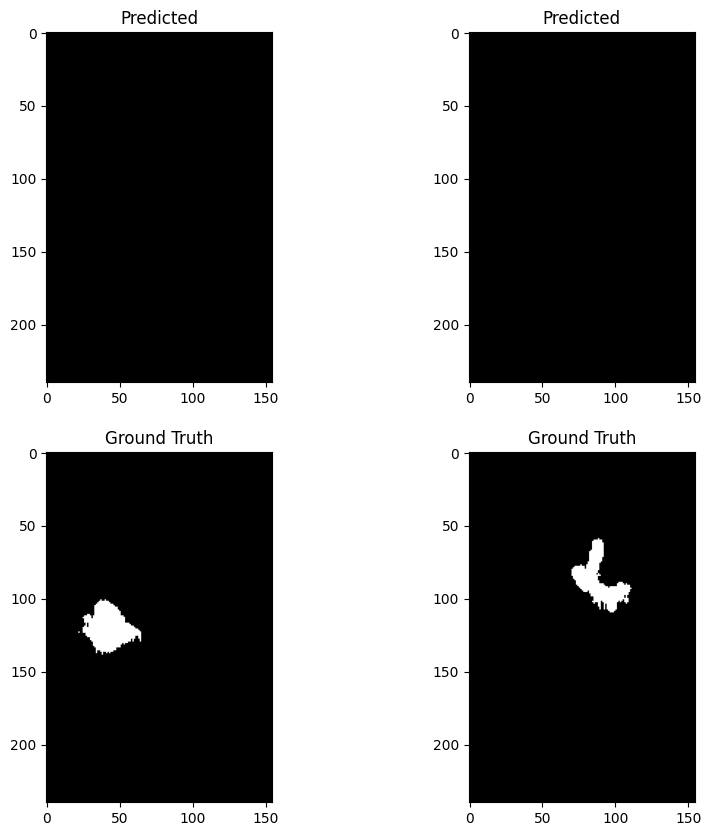

100%|██████████| 472/472 [04:09<00:00,  1.89it/s]



Average Training Loss: 0.156860561133757

Average Training DSC: [0.96965362 0.38821108 0.7690678  0.07723651]
Average Training ASSD: [  7.38863581 180.92002045  83.59745763 268.85007091]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


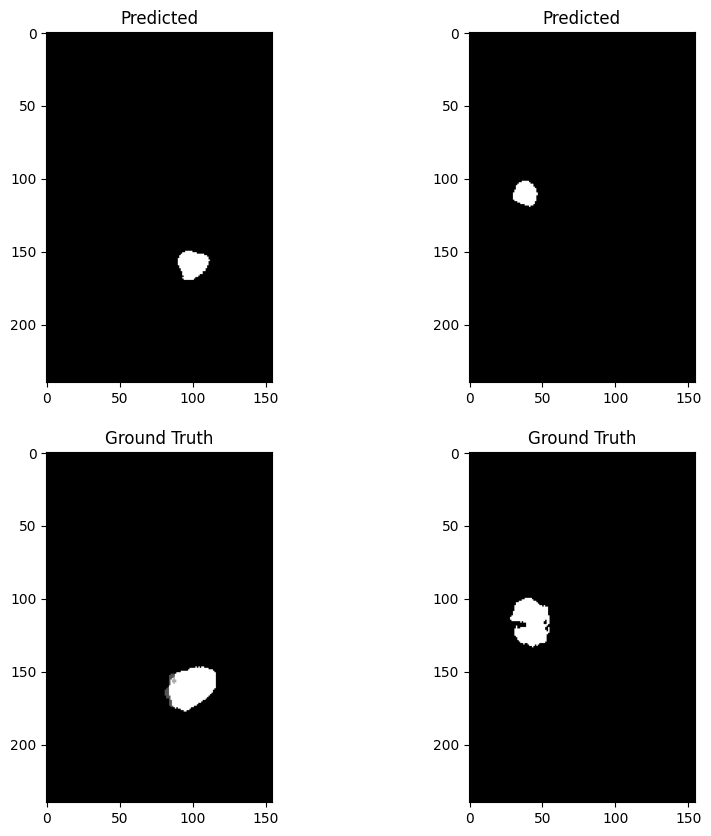

100%|██████████| 118/118 [00:58<00:00,  2.02it/s]


Average Validation Loss: 0.06226521414720406

Average Validation DSC: [0.99335244 0.41705882 0.76165254 0.00389664]
Average Validation ASSD: [  0.84297945 127.77163716  86.28177966 216.4862946 ]
Epoch 2/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


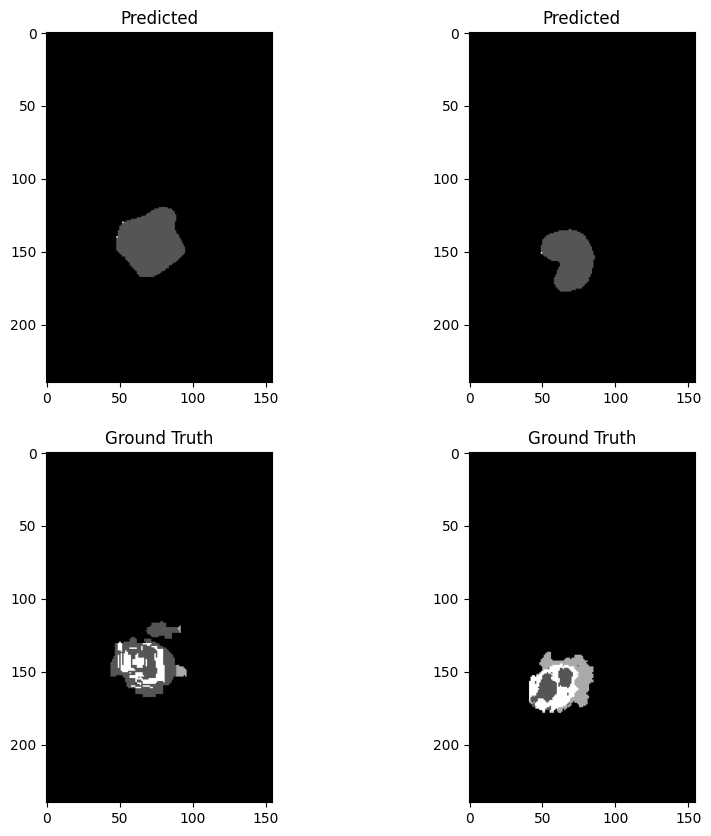

100%|██████████| 472/472 [04:56<00:00,  1.59it/s]



Average Training Loss: 0.05809799221470573

Average Training DSC: [0.99357231 0.36614404 0.76915607 0.26900146]
Average Training ASSD: [  0.76603979 136.24709125  83.56550141  79.92391726]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


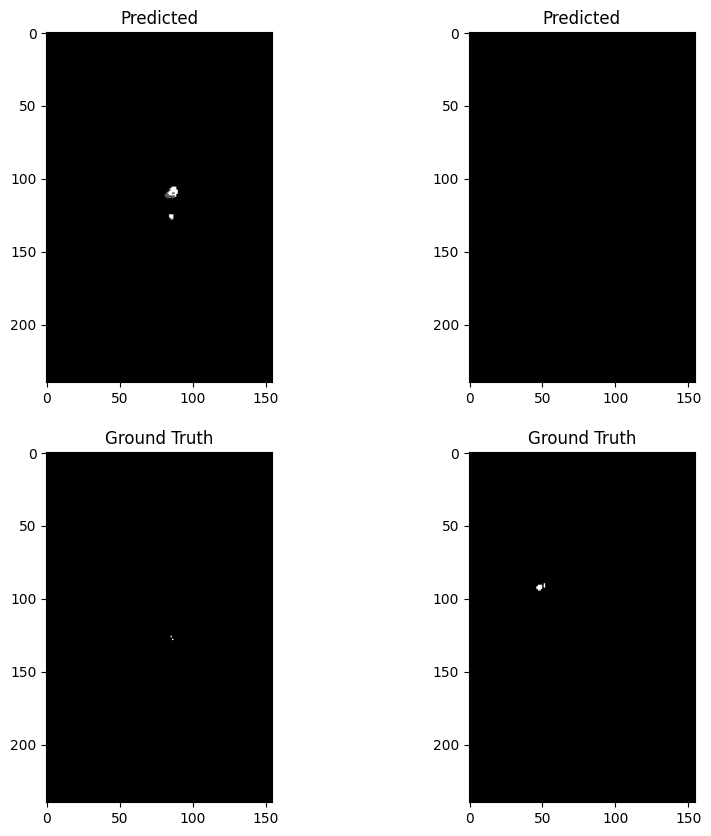

100%|██████████| 118/118 [01:05<00:00,  1.80it/s]


Average Validation Loss: 0.05064112003261255

Average Validation DSC: [0.99541331 0.4294083  0.76165254 0.07288185]
Average Validation ASSD: [  0.51422504 128.92155009  86.28177966 108.90769086]
Epoch 3/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


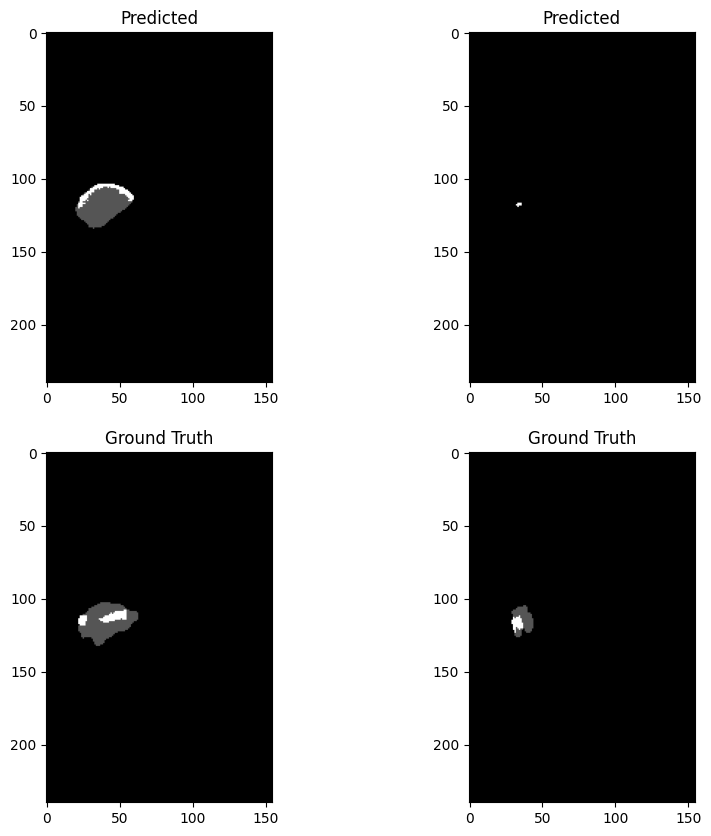

100%|██████████| 472/472 [05:06<00:00,  1.54it/s]



Average Training Loss: 0.046875420065943973

Average Training DSC: [0.99551599 0.36893922 0.76920021 0.33672755]
Average Training ASSD: [  0.51721991 126.73499432  83.54952331  53.66991568]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


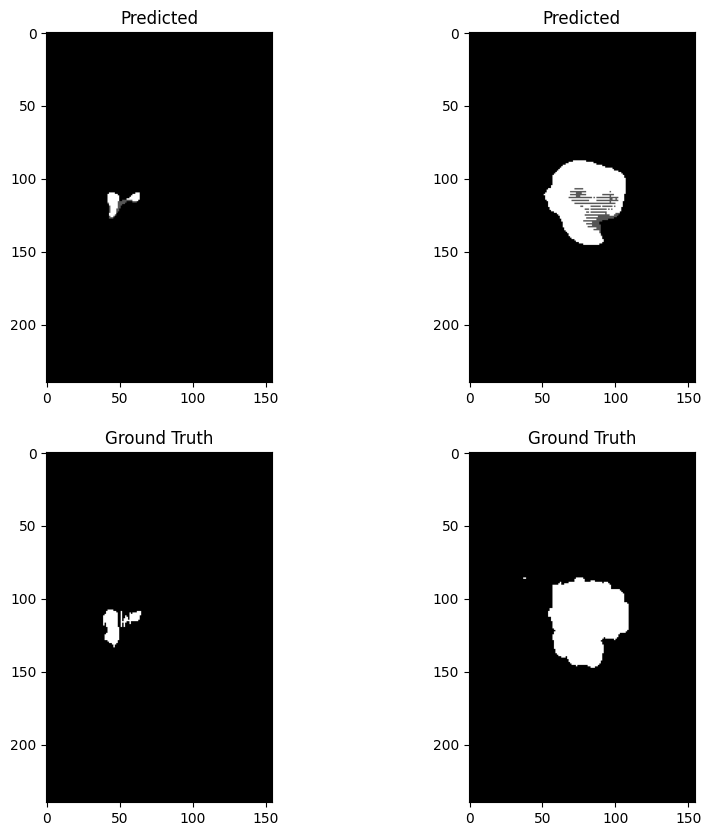

100%|██████████| 118/118 [01:06<00:00,  1.78it/s]


Average Validation Loss: 0.04172156615403749

Average Validation DSC: [0.99609202 0.43574368 0.76165254 0.2708498 ]
Average Validation ASSD: [  0.44951143 123.01160758  86.28177966  50.683668  ]
Epoch 4/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


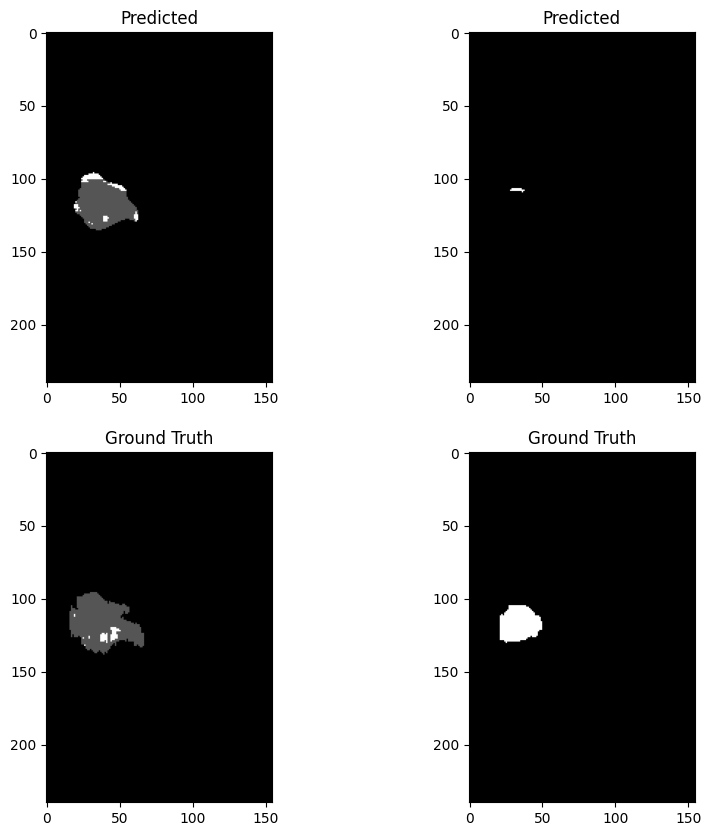

100%|██████████| 472/472 [05:23<00:00,  1.46it/s]



Average Training Loss: 0.039702098796901814

Average Training DSC: [0.9963485  0.42430141 0.74536868 0.36277074]
Average Training ASSD: [  0.40477271 116.17973023  67.50624324  46.697232  ]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


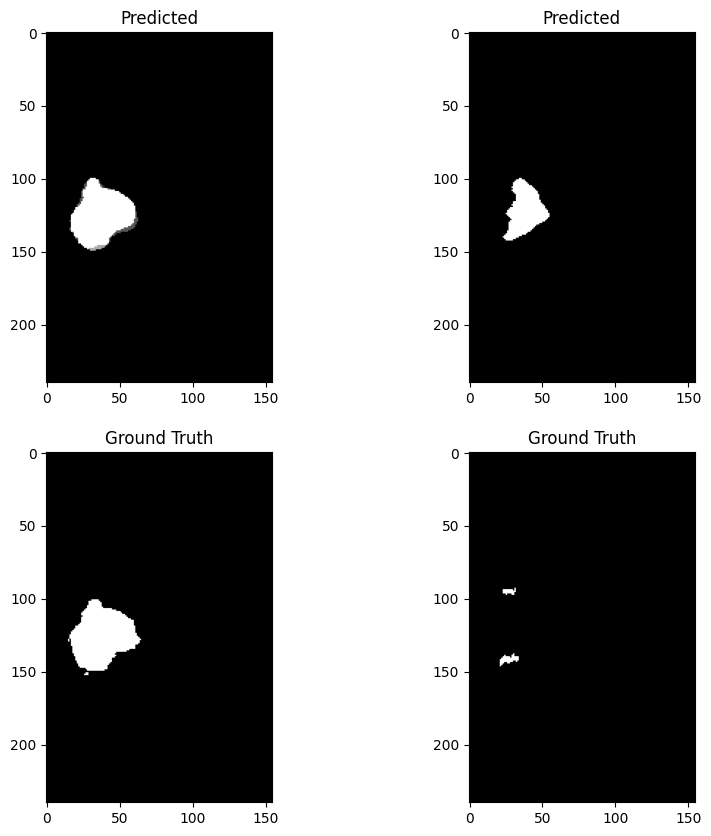

100%|██████████| 118/118 [01:09<00:00,  1.70it/s]


Average Validation Loss: 0.03756776398395078

Average Validation DSC: [0.99672172 0.40877644 0.58799278 0.40989439]
Average Validation ASSD: [  0.38802977 104.36297851 112.42978879  51.90508428]
Epoch 5/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


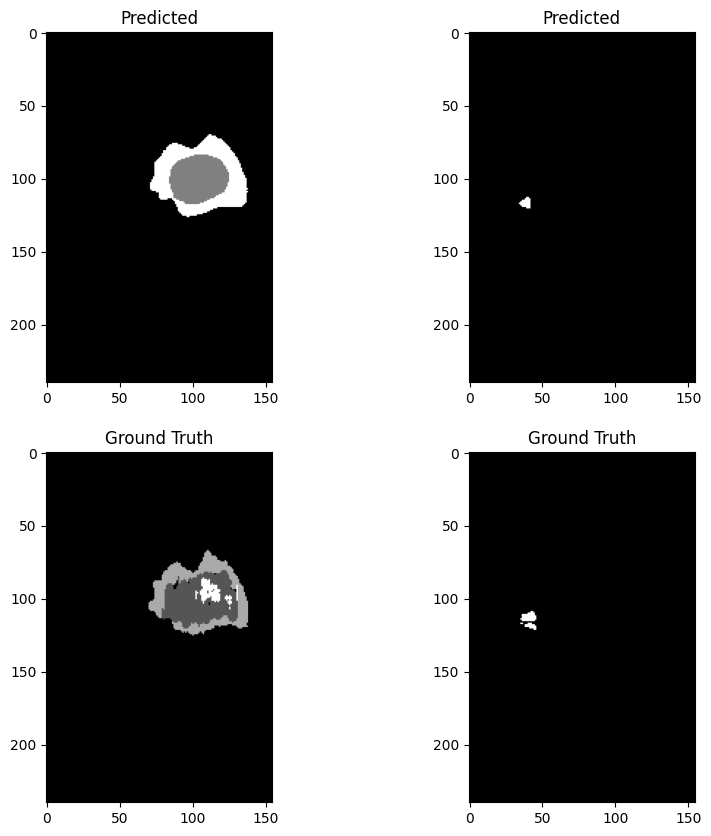

100%|██████████| 472/472 [05:25<00:00,  1.45it/s]



Average Training Loss: 0.03369821768285612

Average Training DSC: [0.99689792 0.51112712 0.78327773 0.40040931]
Average Training ASSD: [  0.34360376 101.76857154  53.42679339  45.41430018]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


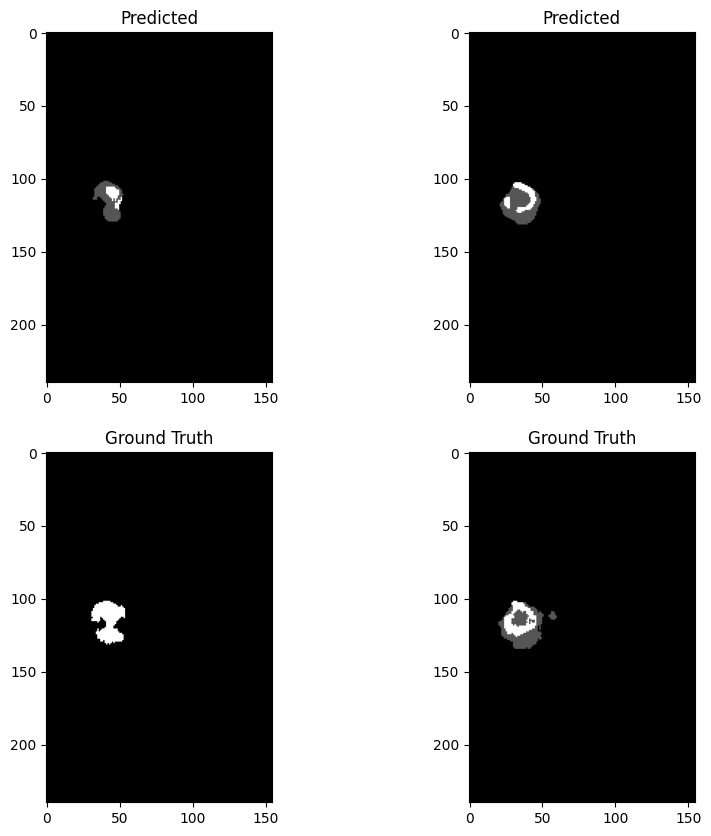

100%|██████████| 118/118 [01:09<00:00,  1.71it/s]


Average Validation Loss: 0.030874688273011628

Average Validation DSC: [0.99710189 0.61054911 0.80425939 0.33317055]
Average Validation ASSD: [ 0.33795899 82.30396865 45.99031065 61.73402687]
Epoch 6/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


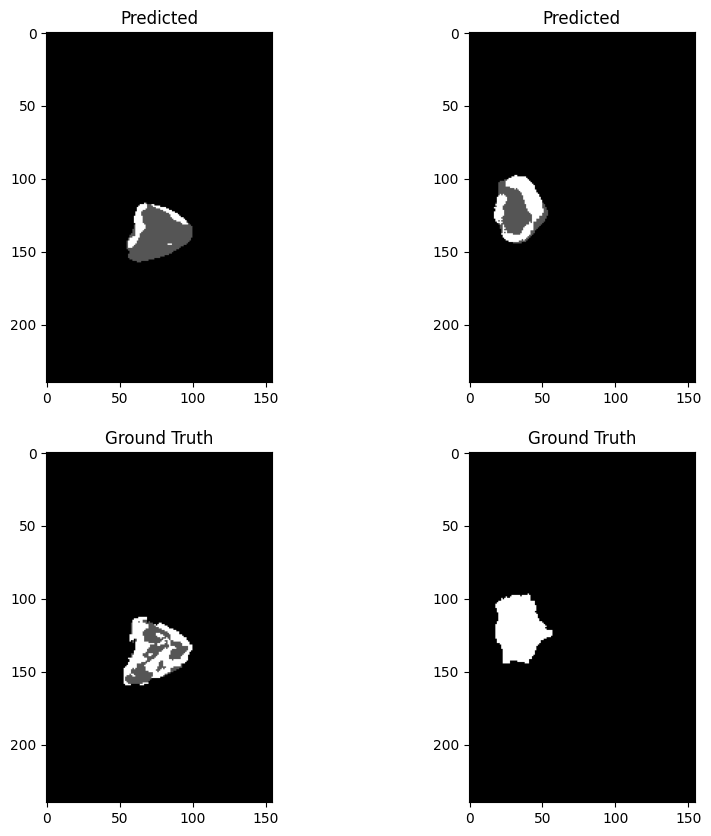

100%|██████████| 472/472 [05:20<00:00,  1.47it/s]



Average Training Loss: 0.030184601883451314

Average Training DSC: [0.99712359 0.60132326 0.79919032 0.44439689]
Average Training ASSD: [ 0.31379648 81.24700265 50.20282919 49.17420707]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


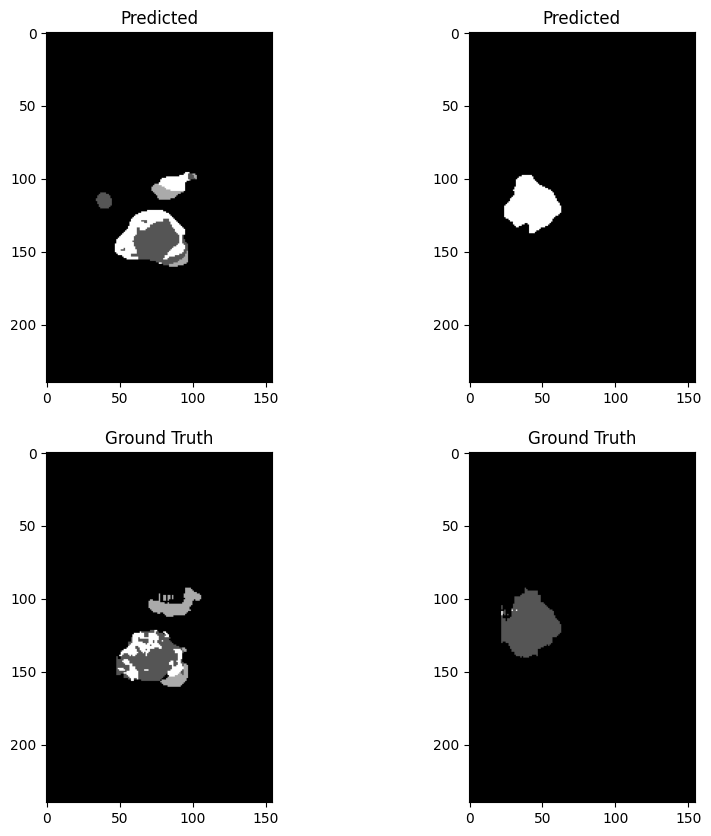

100%|██████████| 118/118 [01:10<00:00,  1.66it/s]


Average Validation Loss: 0.027485153322123874

Average Validation DSC: [0.99716712 0.63188639 0.80850103 0.40251561]
Average Validation ASSD: [ 0.30659261 78.28245281 45.87802825 79.20779299]
Epoch 7/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


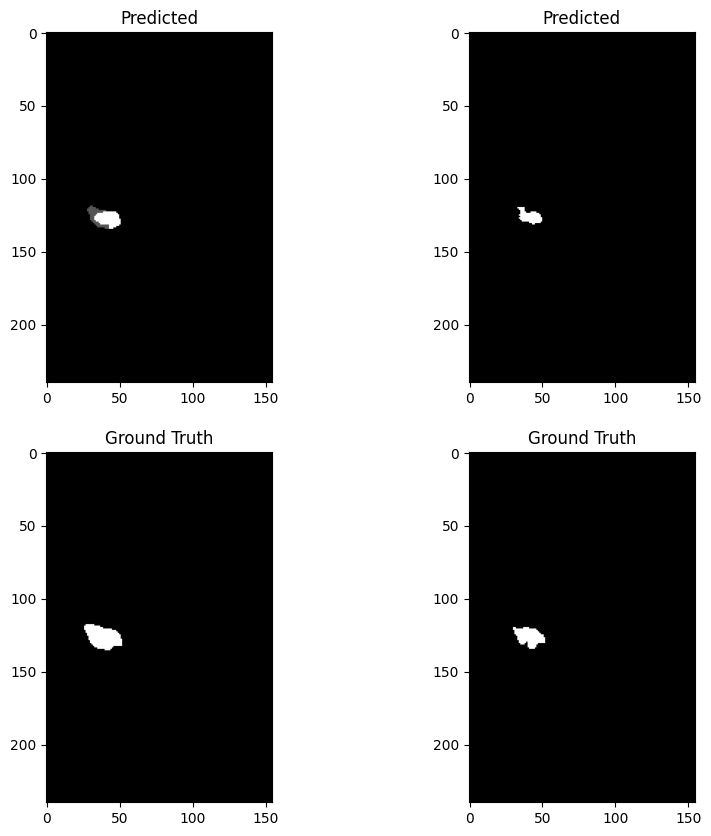

100%|██████████| 472/472 [05:22<00:00,  1.47it/s]



Average Training Loss: 0.02537024976543577

Average Training DSC: [0.99748881 0.69293819 0.81819009 0.50078613]
Average Training ASSD: [ 0.26444533 58.42970231 43.64349991 51.80610432]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


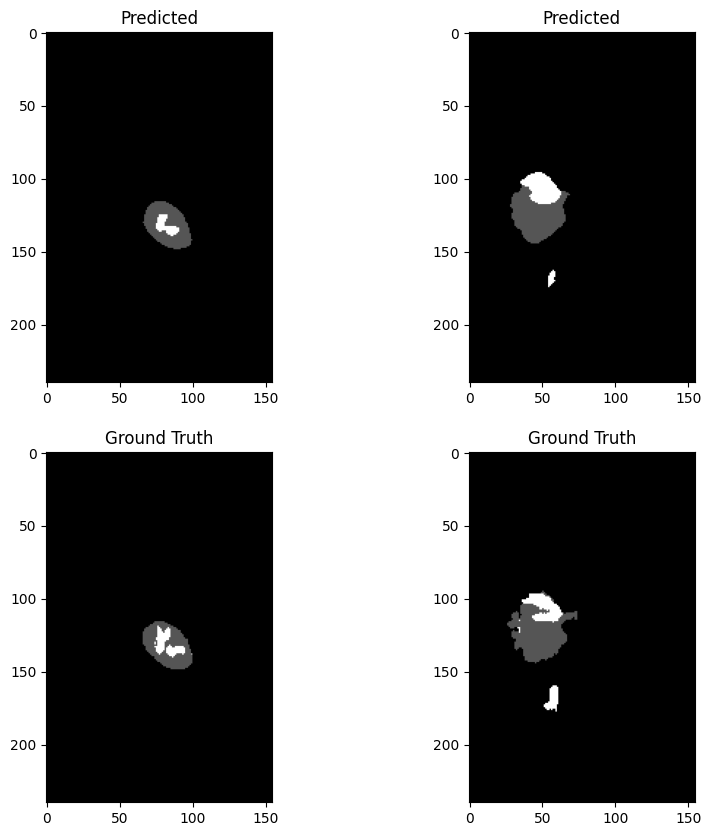

100%|██████████| 118/118 [01:08<00:00,  1.72it/s]


Average Validation Loss: 0.022995933345755785

Average Validation DSC: [0.99771545 0.75335465 0.8323328  0.54858841]
Average Validation ASSD: [ 0.23907401 40.18294642 38.7872993  34.29348575]
Epoch 8/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


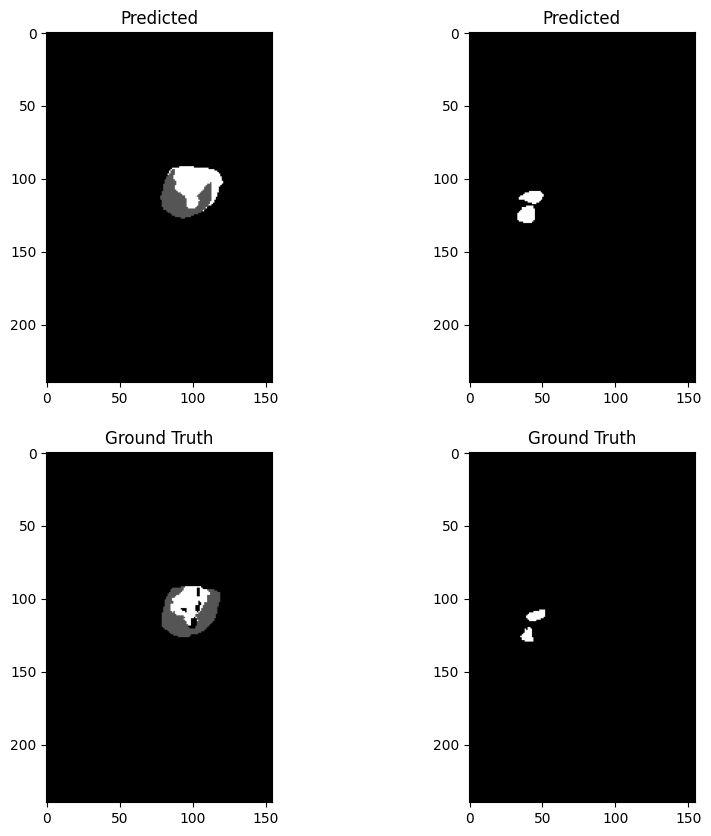

100%|██████████| 472/472 [05:36<00:00,  1.40it/s]



Average Training Loss: 0.021542968183077115

Average Training DSC: [0.99773131 0.76034295 0.8476173  0.54828439]
Average Training ASSD: [ 0.23539325 41.77605054 33.97082034 48.10220435]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


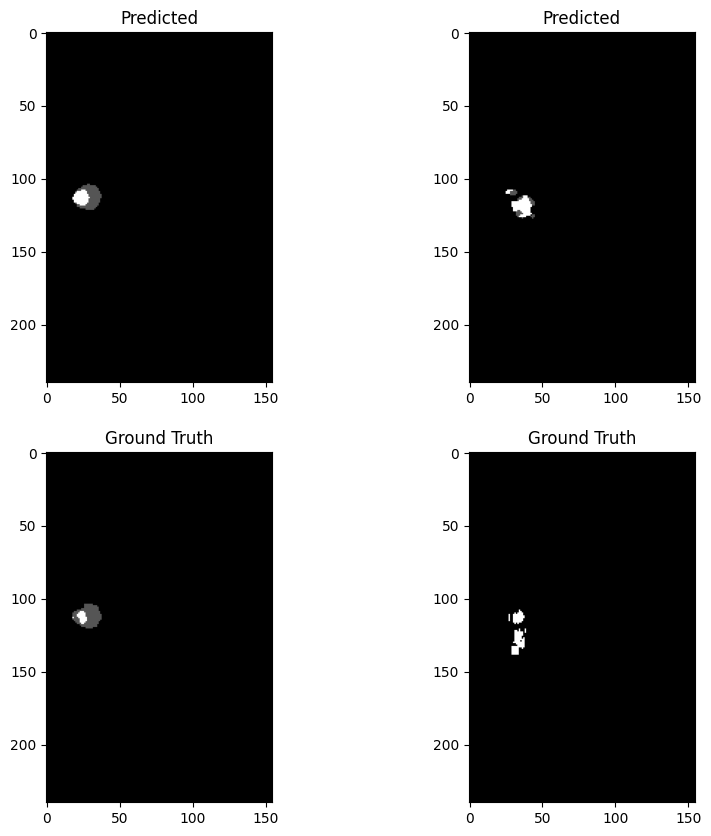

100%|██████████| 118/118 [01:12<00:00,  1.62it/s]


Average Validation Loss: 0.02054394235424066

Average Validation DSC: [0.99788256 0.73890859 0.85866032 0.50844981]
Average Validation ASSD: [ 0.21799801 52.32934989 30.84933733 68.52059947]
Epoch 9/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


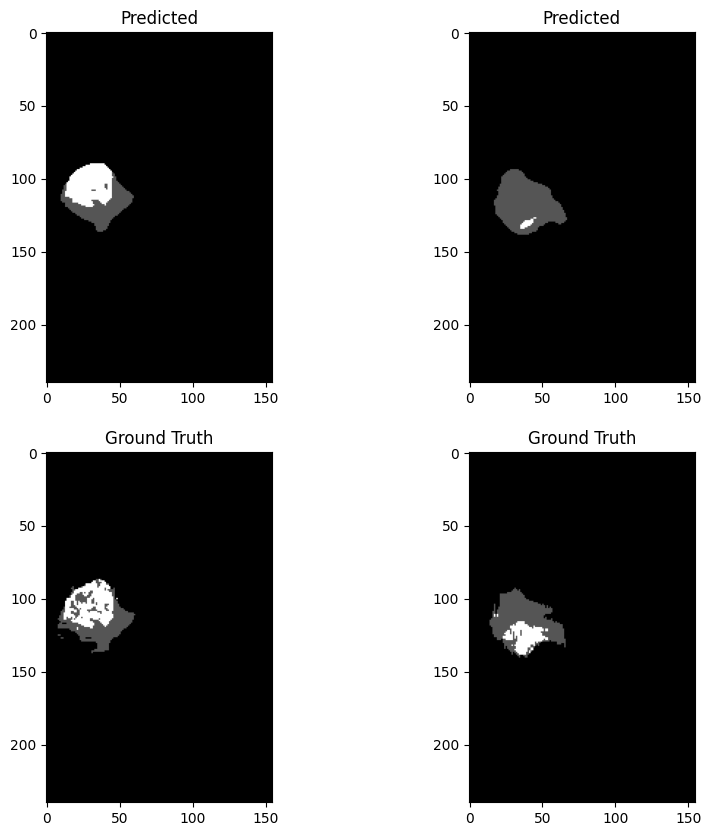

100%|██████████| 472/472 [05:27<00:00,  1.44it/s]



Average Training Loss: 0.019512381126425404

Average Training DSC: [0.99790199 0.79291837 0.86461684 0.58393876]
Average Training ASSD: [ 0.21296244 34.08403841 27.74257741 45.86560067]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


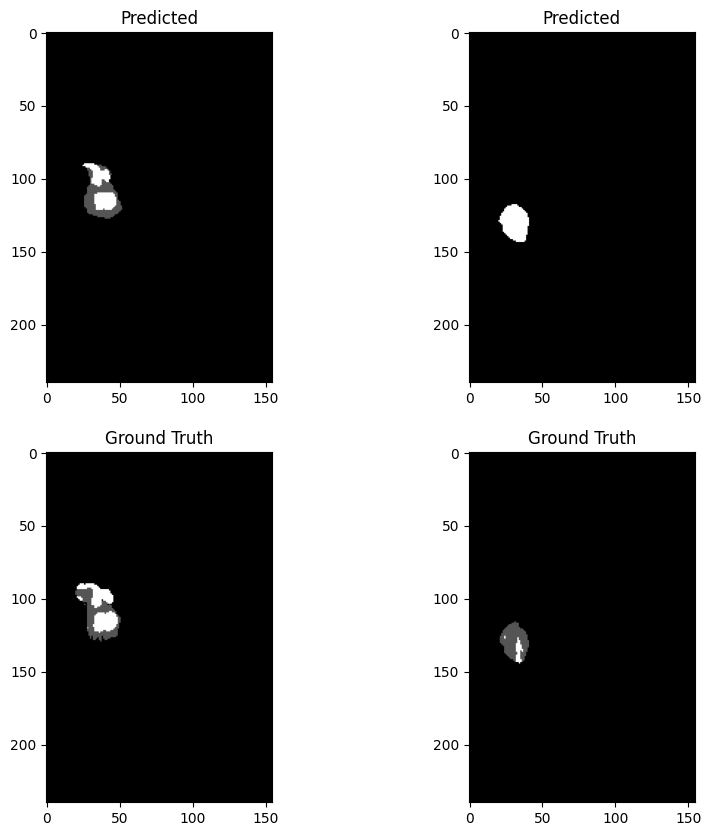

100%|██████████| 118/118 [01:28<00:00,  1.33it/s]


Average Validation Loss: 0.020802926406327447

Average Validation DSC: [0.99781344 0.78138545 0.85850563 0.61565792]
Average Validation ASSD: [ 0.20697269 31.21921943 31.44250087 25.45013143]
Epoch 10/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


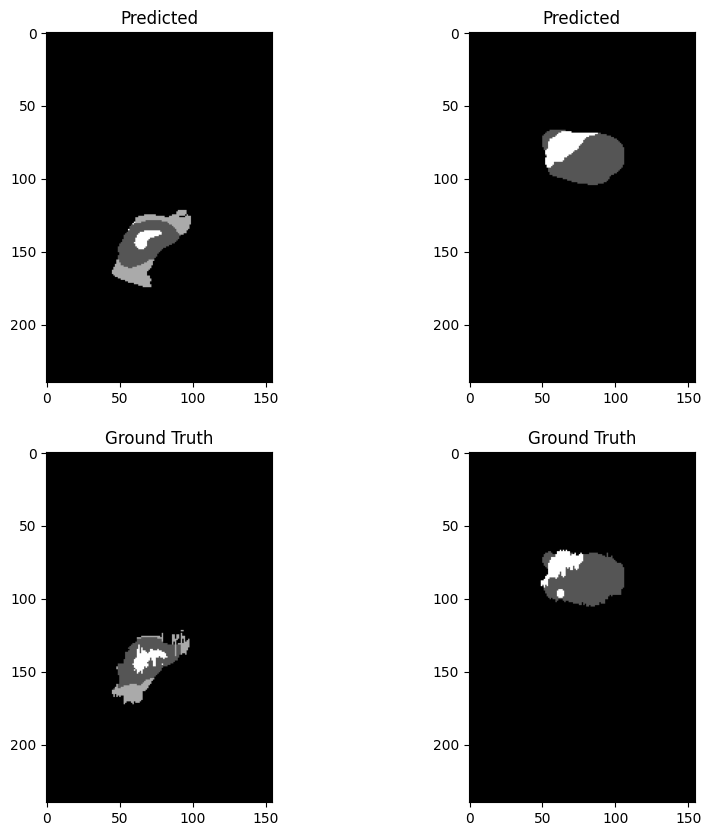

100%|██████████| 472/472 [06:25<00:00,  1.22it/s]



Average Training Loss: 0.018218205251210068

Average Training DSC: [0.99798568 0.8116214  0.86989119 0.60003823]
Average Training ASSD: [ 0.20603018 29.00455972 26.1236076  46.59261643]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


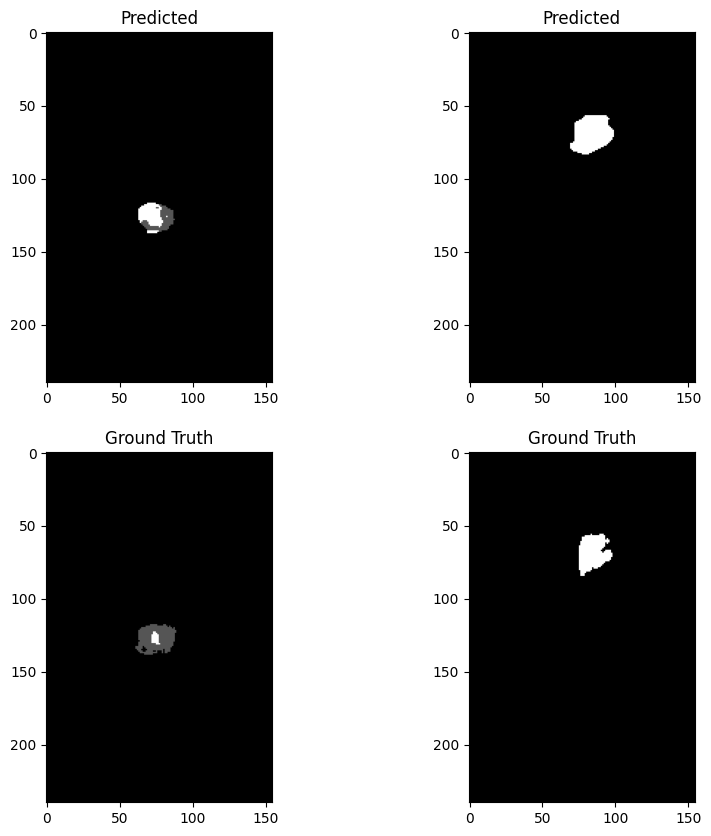

100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Average Validation Loss: 0.01947872079435294

Average Validation DSC: [0.99797661 0.81950385 0.85862118 0.63810322]
Average Validation ASSD: [ 0.19771717 23.25566751 24.79787917 23.71159671]
Epoch 11/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


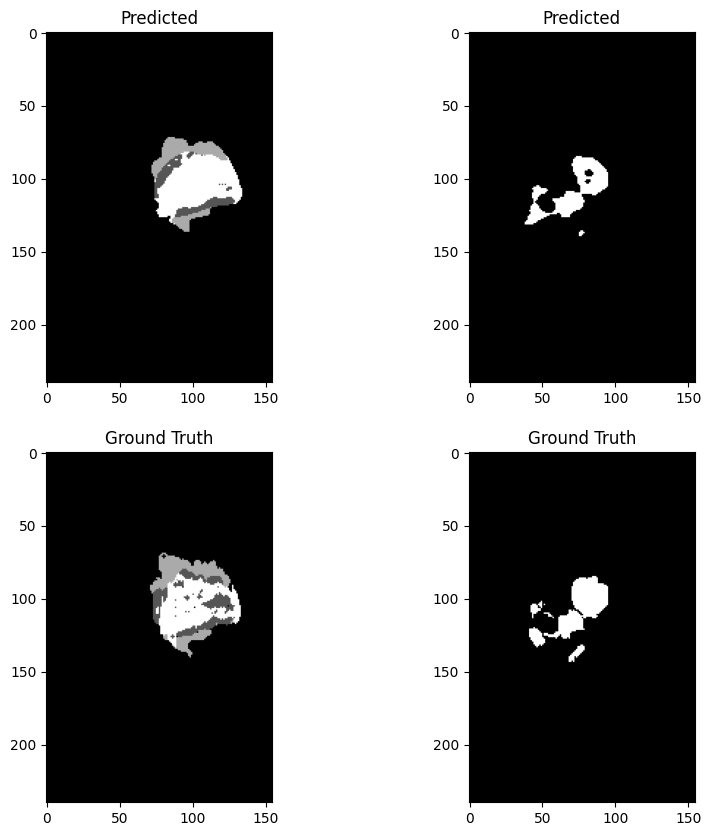

100%|██████████| 472/472 [05:24<00:00,  1.46it/s]



Average Training Loss: 0.016904046503487594

Average Training DSC: [0.99812912 0.82902124 0.88092917 0.6240749 ]
Average Training ASSD: [ 0.19267537 25.15320165 22.04224165 43.56701698]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


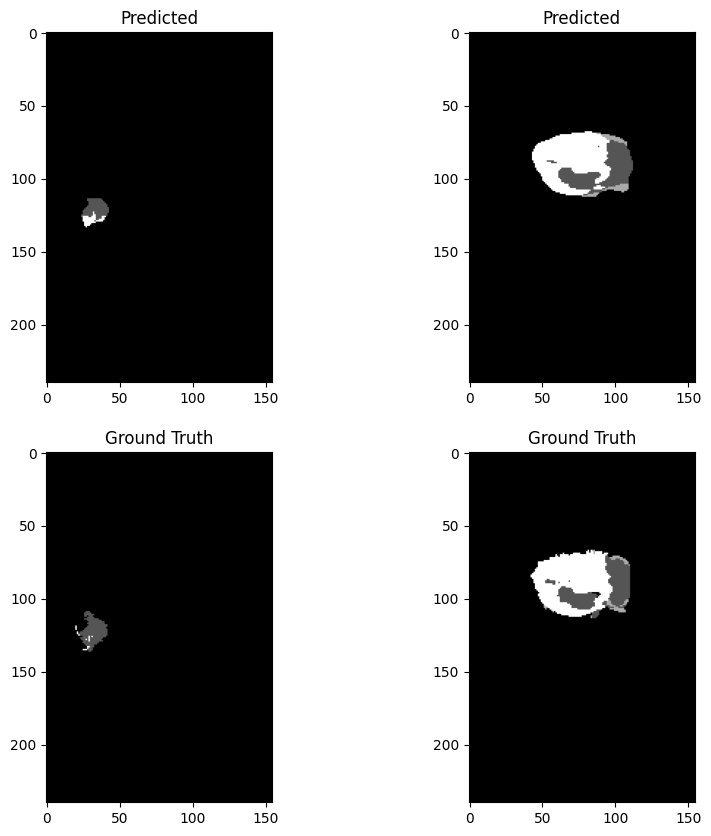

100%|██████████| 118/118 [01:09<00:00,  1.70it/s]


Average Validation Loss: 0.016849031581117186

Average Validation DSC: [0.99821107 0.82081175 0.88973845 0.58250329]
Average Validation ASSD: [ 0.18003916 30.45308248 20.05968488 53.75923297]
Epoch 12/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


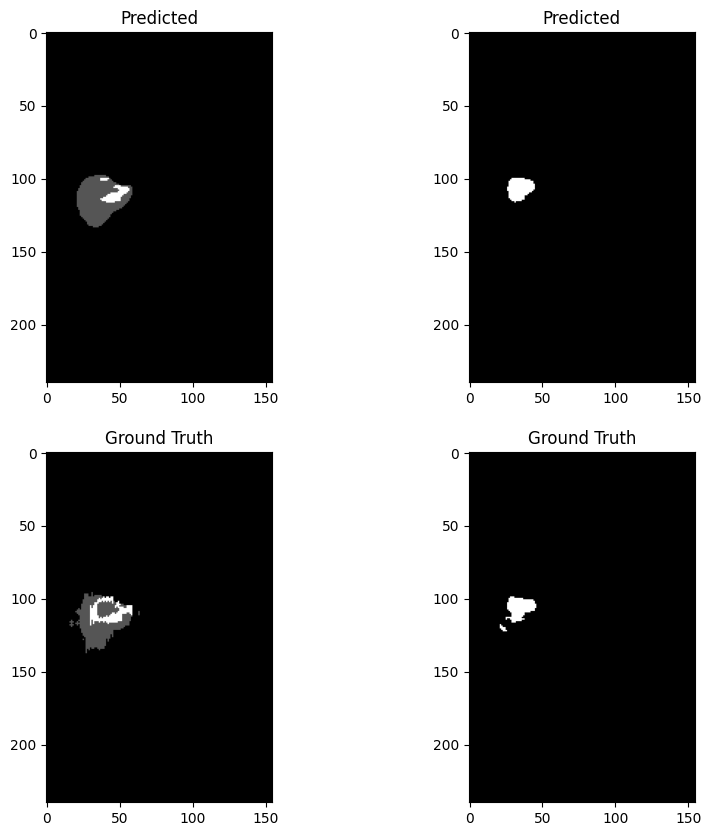

100%|██████████| 472/472 [06:13<00:00,  1.26it/s]



Average Training Loss: 0.01518877946487549

Average Training DSC: [0.99829785 0.8468915  0.89526052 0.64363589]
Average Training ASSD: [ 0.16932761 21.40136368 18.78827213 40.72766238]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


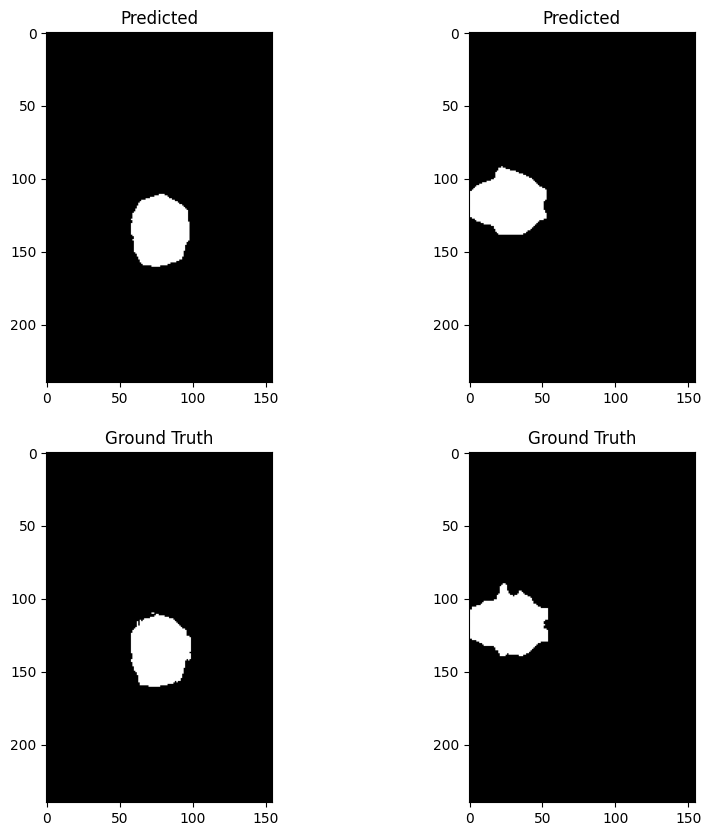

100%|██████████| 118/118 [01:49<00:00,  1.07it/s]


Average Validation Loss: 0.016567016549219014

Average Validation DSC: [0.99811269 0.83834969 0.89100824 0.59923355]
Average Validation ASSD: [ 0.18335254 22.07364088 18.33917164 51.66269   ]
Epoch 13/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


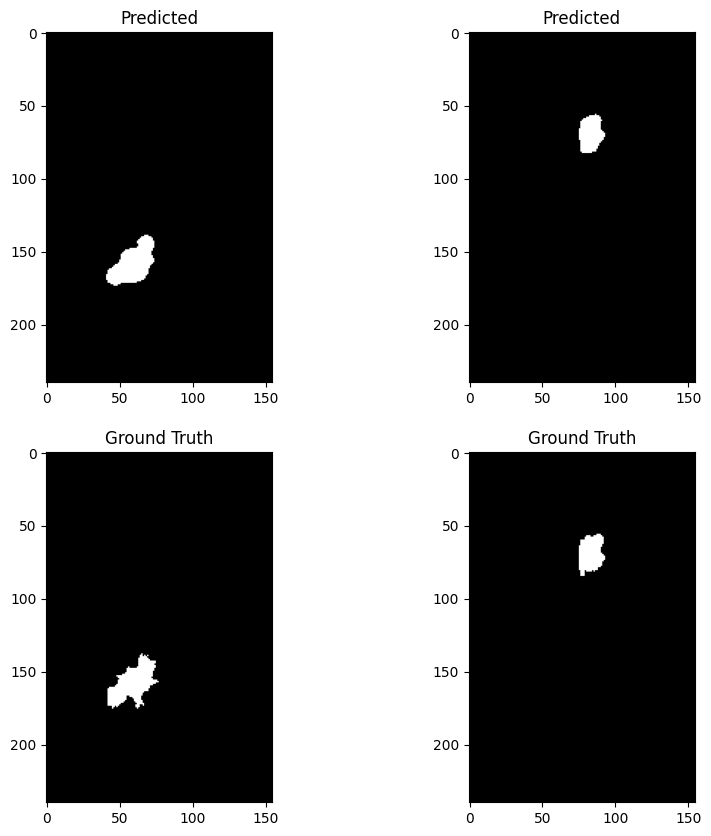

100%|██████████| 472/472 [06:49<00:00,  1.15it/s]



Average Training Loss: 0.014677342162585929

Average Training DSC: [0.99834561 0.85328886 0.90012251 0.65639671]
Average Training ASSD: [ 0.16546691 20.51535951 17.76810931 38.43601589]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


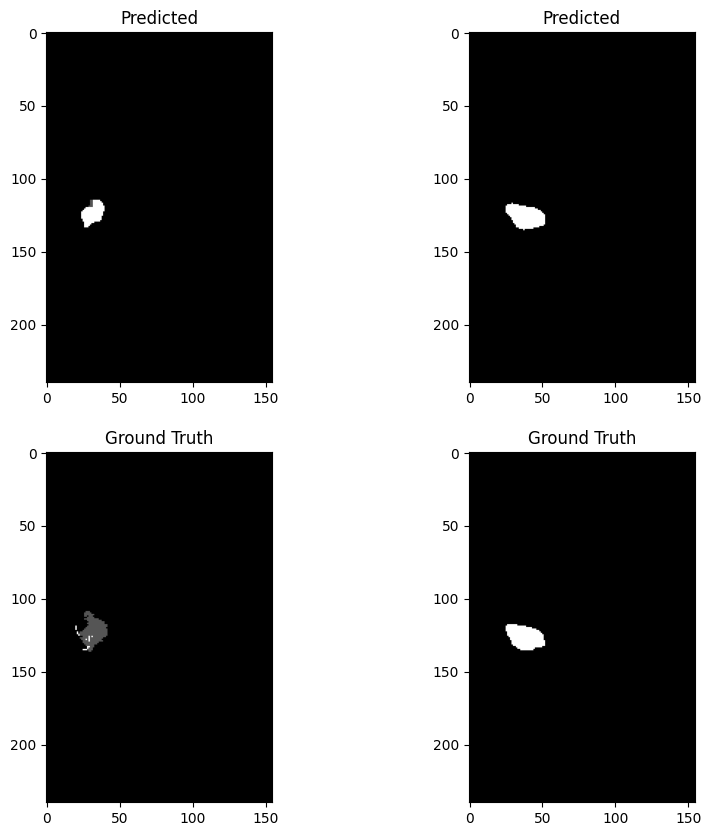

100%|██████████| 118/118 [01:11<00:00,  1.66it/s]


Average Validation Loss: 0.016099994378637964

Average Validation DSC: [0.99835122 0.84656846 0.89622277 0.6638478 ]
Average Validation ASSD: [ 0.17126949 19.45694118 17.32317712 28.6597178 ]
Epoch 14/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


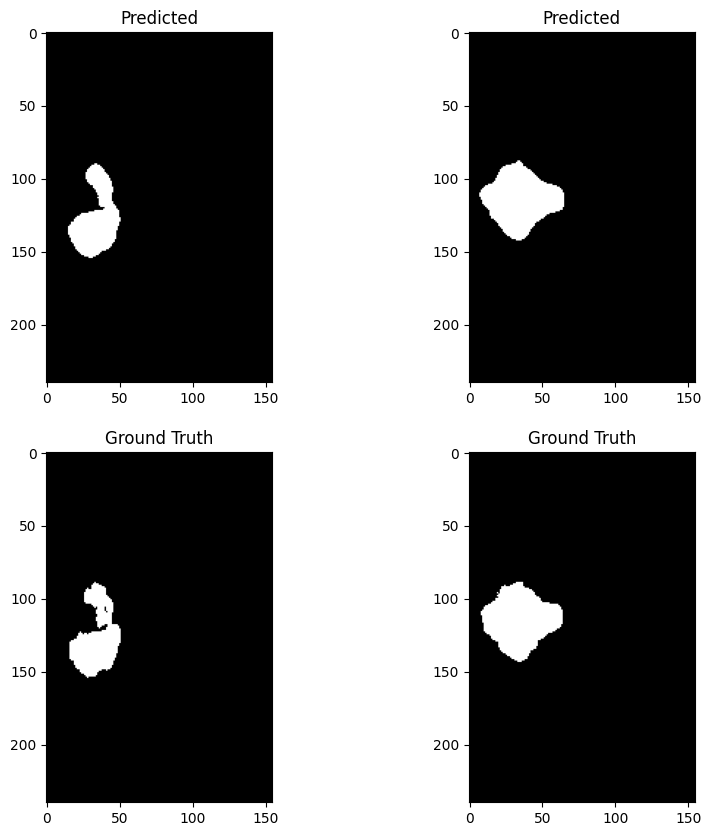

100%|██████████| 472/472 [05:27<00:00,  1.44it/s]



Average Training Loss: 0.013979115056750065

Average Training DSC: [0.99840502 0.86193375 0.89868373 0.66855722]
Average Training ASSD: [ 0.15804731 17.60975508 18.40887393 36.77599211]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


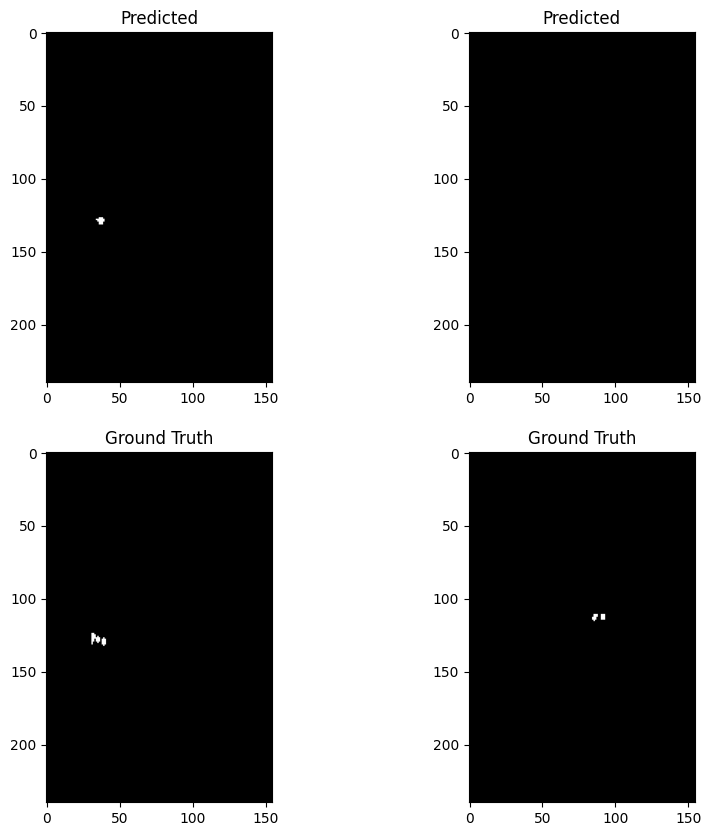

100%|██████████| 118/118 [01:11<00:00,  1.66it/s]


Average Validation Loss: 0.014920953286306585

Average Validation DSC: [0.99832132 0.85235455 0.90308083 0.64884637]
Average Validation ASSD: [ 0.18333866 19.27261624 16.91417777 38.02059224]
Epoch 15/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


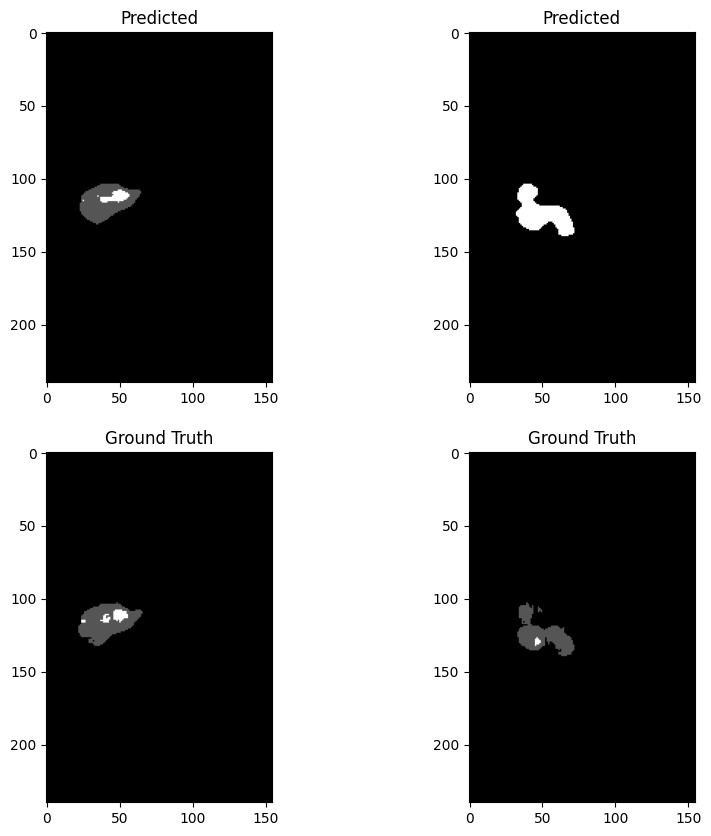

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.013338291536132663

Average Training DSC: [0.99847723 0.86673716 0.90675329 0.68006987]
Average Training ASSD: [ 0.14868655 17.57089111 17.04864755 35.42395067]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


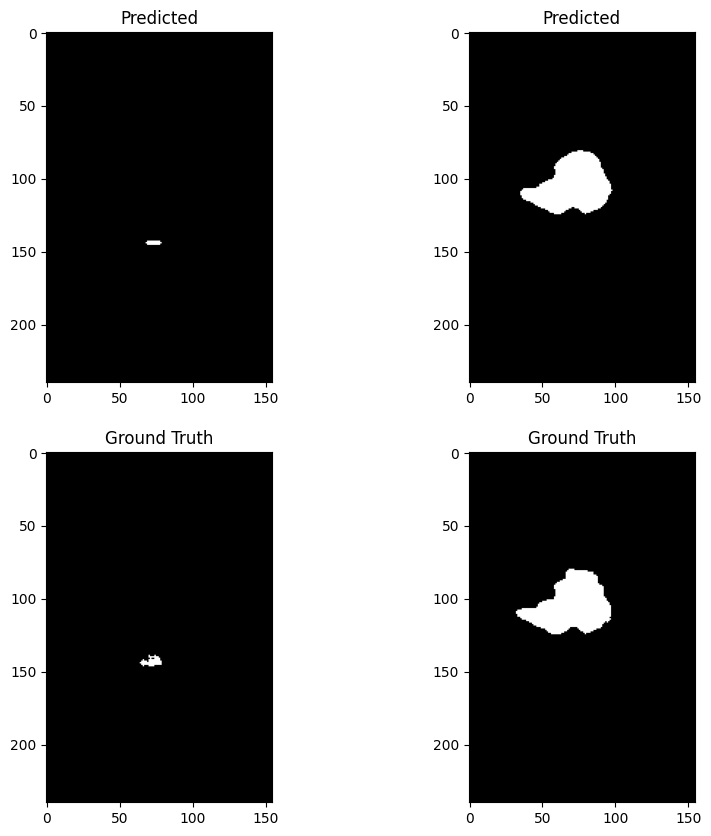

100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Average Validation Loss: 0.014104671342203678

Average Validation DSC: [0.99845959 0.86107946 0.9120338  0.66364446]
Average Validation ASSD: [ 0.16008798 17.6879777  14.93165355 37.50936248]
Epoch 16/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


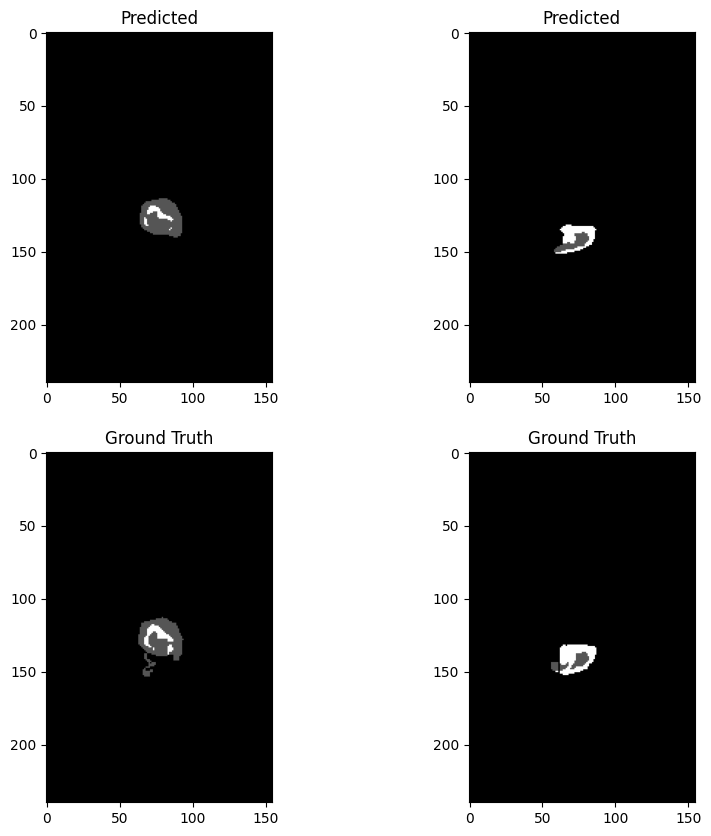

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.012794863990058143

Average Training DSC: [0.99853548 0.87042736 0.90924837 0.68663902]
Average Training ASSD: [ 0.14505694 16.44885805 16.27056497 34.75827994]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


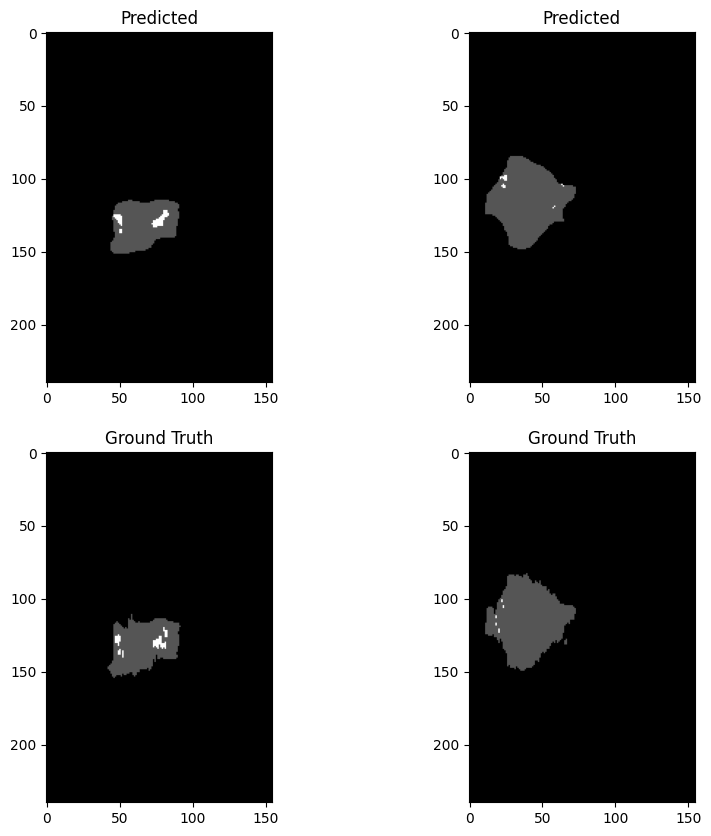

100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Average Validation Loss: 0.0133968865325264

Average Validation DSC: [0.99855079 0.86897087 0.9076821  0.68901376]
Average Validation ASSD: [ 0.15005629 17.44896854 15.88094608 31.27143835]
Epoch 17/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


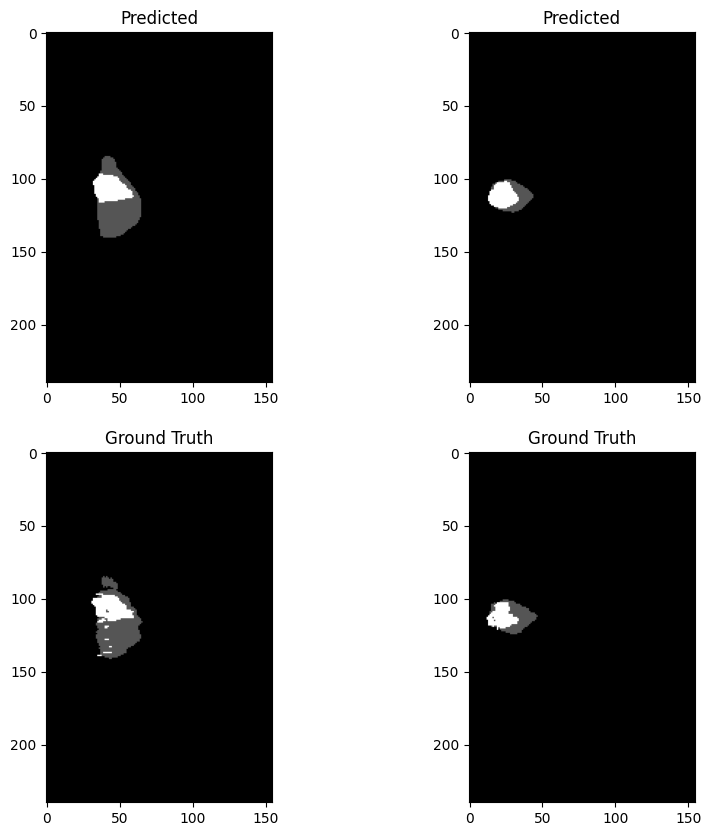

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.011858213986901536

Average Training DSC: [0.99861037 0.88275463 0.91666124 0.70081049]
Average Training ASSD: [ 0.13534067 13.68520791 14.56715432 32.06230289]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


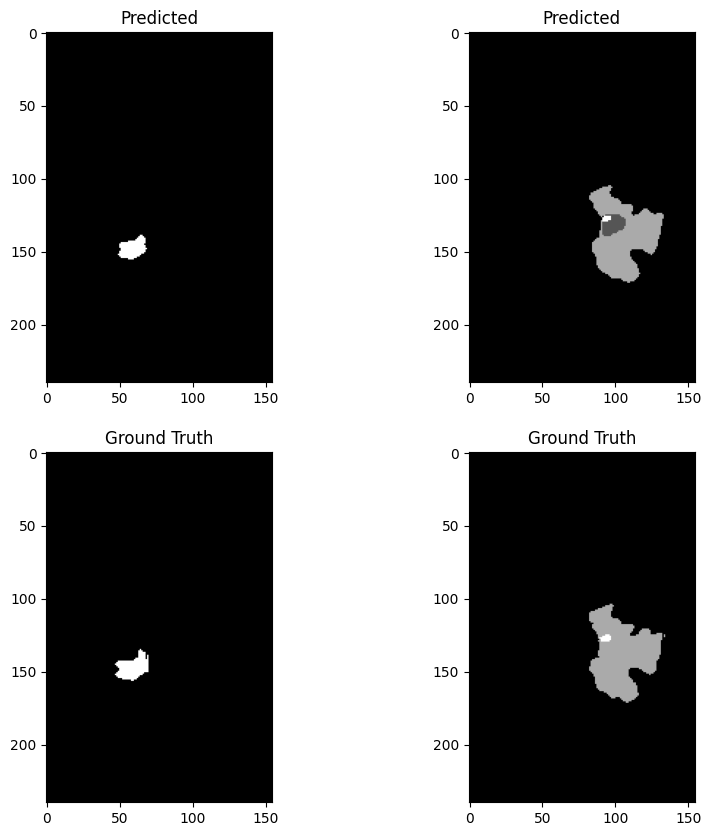

100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Average Validation Loss: 0.014006727098850376

Average Validation DSC: [0.99842884 0.86493393 0.89736936 0.66921921]
Average Validation ASSD: [ 0.15088125 18.3950411  17.09935735 39.5431157 ]
Epoch 18/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


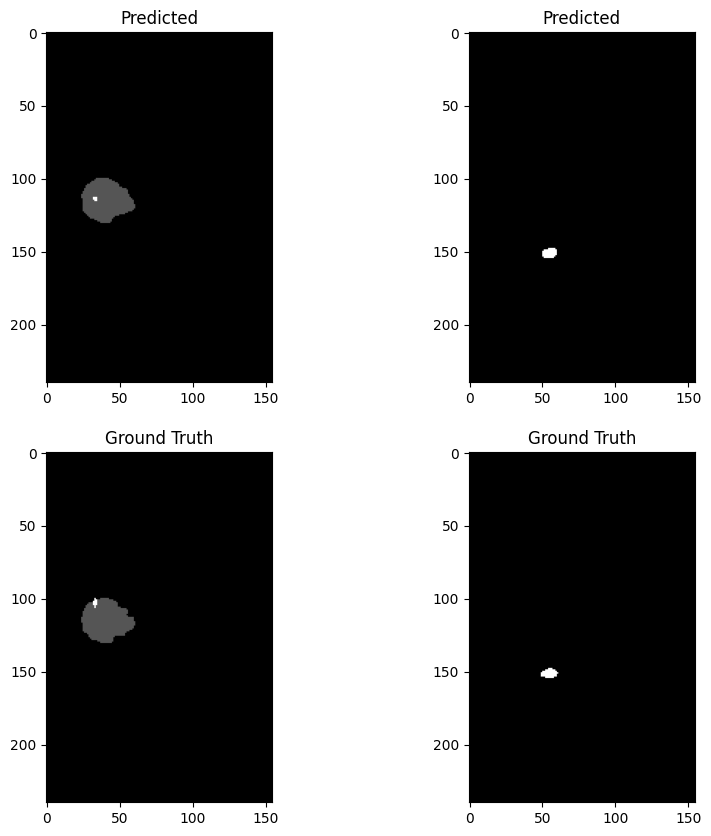

100%|██████████| 472/472 [05:31<00:00,  1.43it/s]



Average Training Loss: 0.012007749083025729

Average Training DSC: [0.99863988 0.88107262 0.91197275 0.6997868 ]
Average Training ASSD: [ 0.13153866 14.48993186 16.14600485 32.49901736]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


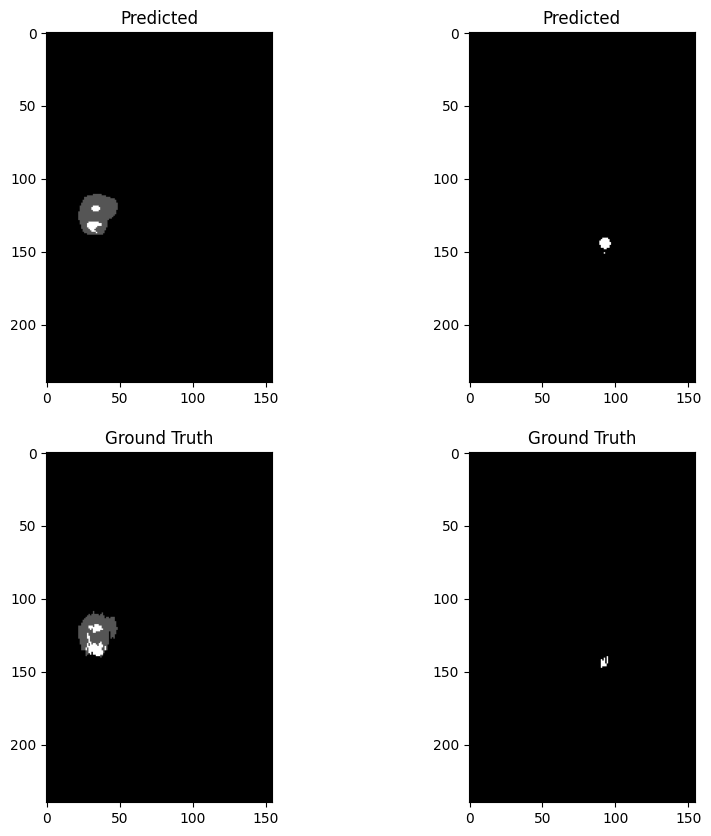

100%|██████████| 118/118 [01:12<00:00,  1.64it/s]


Average Validation Loss: 0.013982805837798169

Average Validation DSC: [0.99854186 0.84591542 0.90008827 0.68190558]
Average Validation ASSD: [ 0.14173005 23.41469426 17.49765095 32.65897973]
Epoch 19/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


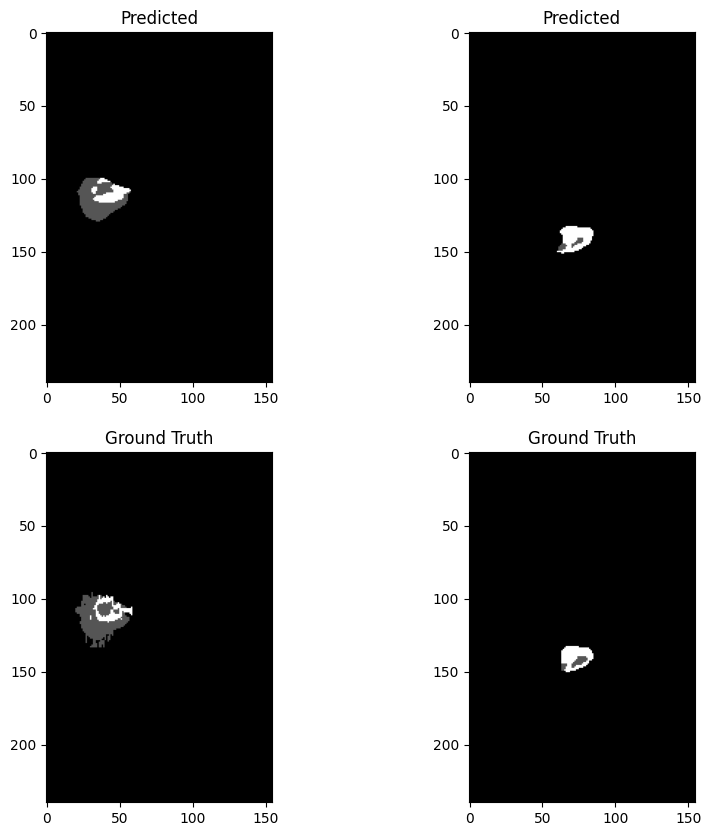

100%|██████████| 472/472 [05:30<00:00,  1.43it/s]



Average Training Loss: 0.012166342697051054

Average Training DSC: [0.998611   0.87765026 0.91395745 0.7013027 ]
Average Training ASSD: [ 0.13538193 15.1750681  14.82275221 31.23835573]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


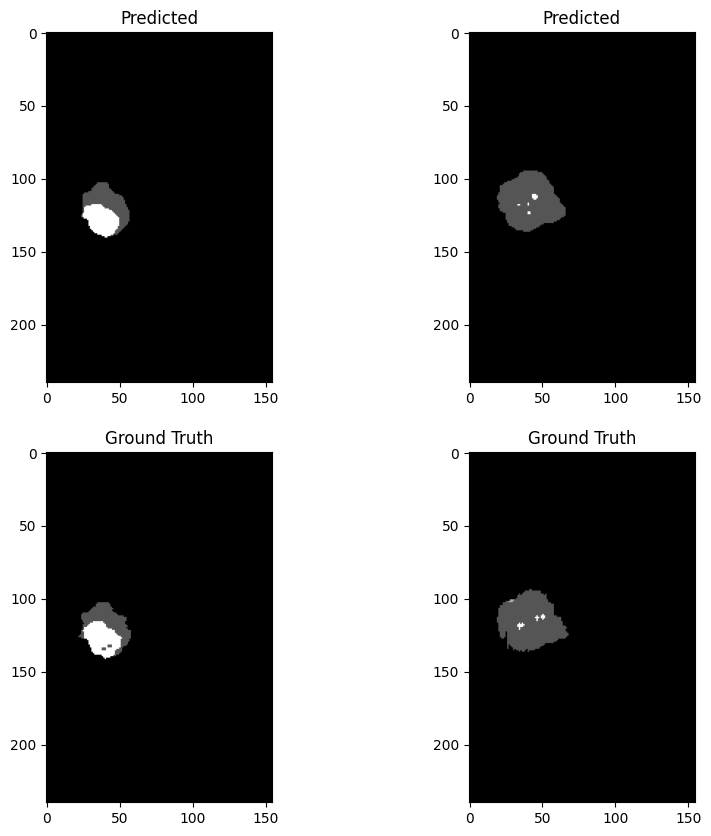

100%|██████████| 118/118 [01:09<00:00,  1.69it/s]


Average Validation Loss: 0.014499665932508848

Average Validation DSC: [0.9984247  0.86081967 0.91308371 0.65956617]
Average Validation ASSD: [ 0.1741901  18.98711206 14.38661365 39.37634143]
Epoch 20/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


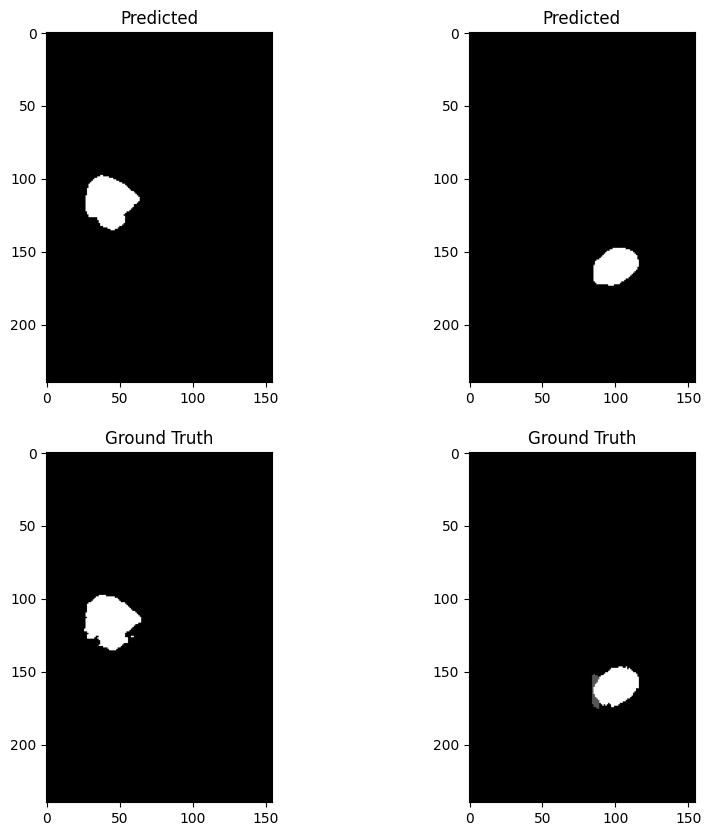

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.011411047602759012

Average Training DSC: [0.99869438 0.88473832 0.91386883 0.71052794]
Average Training ASSD: [ 0.12763276 14.27862408 16.18548168 30.57221804]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


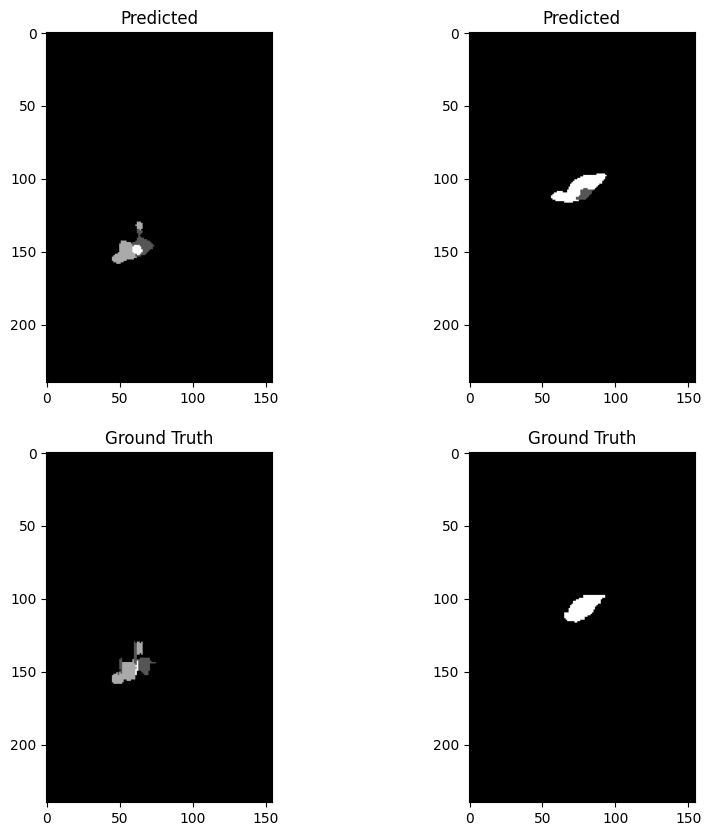

100%|██████████| 118/118 [01:11<00:00,  1.66it/s]


Average Validation Loss: 0.013967689769973948

Average Validation DSC: [0.99857138 0.8409665  0.90557514 0.66016677]
Average Validation ASSD: [ 0.13849376 26.28668864 17.67586942 42.26990326]
Epoch 21/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


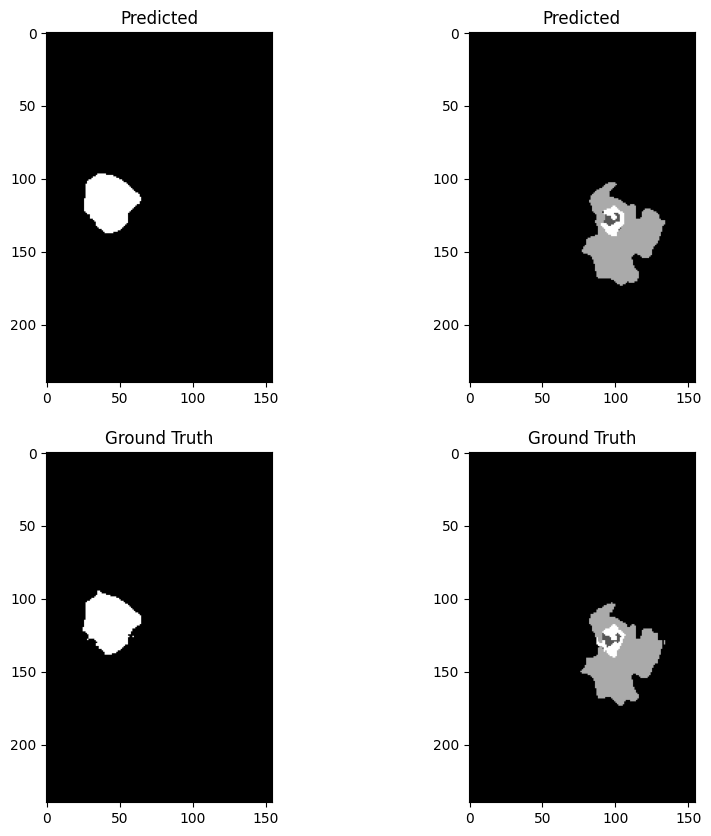

100%|██████████| 472/472 [05:28<00:00,  1.44it/s]



Average Training Loss: 0.010687591915977804

Average Training DSC: [0.99876724 0.89185054 0.918228   0.72417444]
Average Training ASSD: [ 0.11920321 13.38140316 14.64523886 30.92205764]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


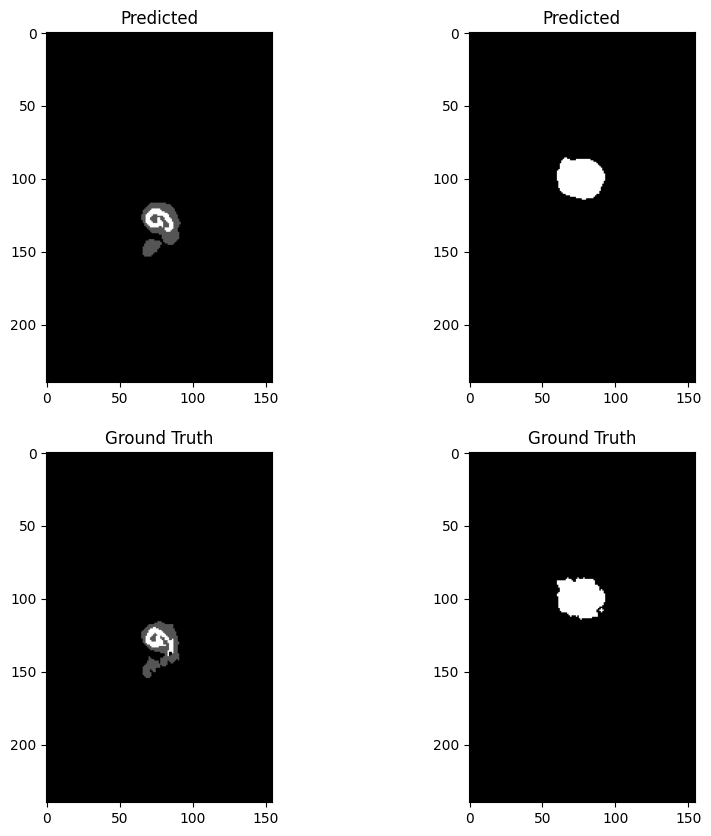

100%|██████████| 118/118 [01:15<00:00,  1.57it/s]


Average Validation Loss: 0.012044726618391982

Average Validation DSC: [0.99876791 0.88471417 0.91427094 0.71184342]
Average Validation ASSD: [ 0.12165858 15.45053586 15.64540408 29.52081412]
Epoch 22/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


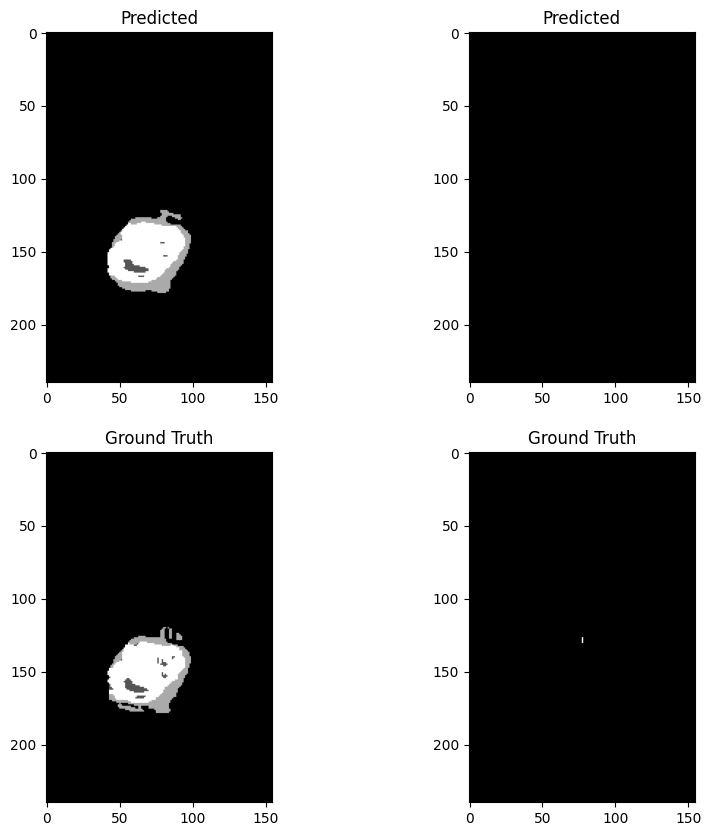

100%|██████████| 472/472 [05:48<00:00,  1.36it/s]



Average Training Loss: 0.010361030305167503

Average Training DSC: [0.9987946  0.89611631 0.92129176 0.72909083]
Average Training ASSD: [ 0.11594773 12.12903058 14.31006338 28.59147121]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


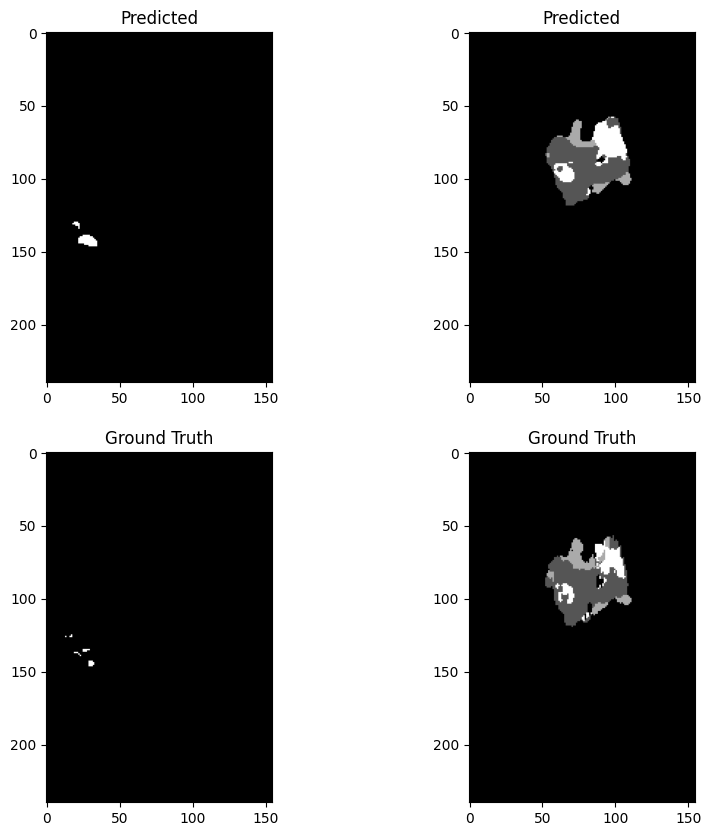

100%|██████████| 118/118 [01:15<00:00,  1.56it/s]


Average Validation Loss: 0.011874327724168108

Average Validation DSC: [0.9987467  0.88541482 0.92092362 0.72111068]
Average Validation ASSD: [ 0.11805587 13.94267176 13.88996613 19.37112114]
Epoch 23/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


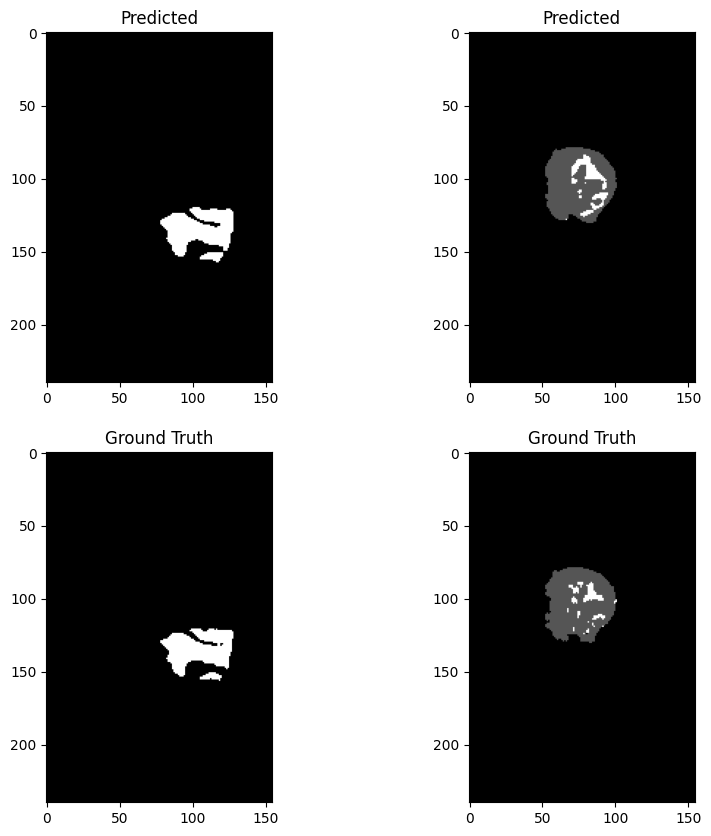

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.009611206378795648

Average Training DSC: [0.99890608 0.90545712 0.92806111 0.74060752]
Average Training ASSD: [ 0.10502729 10.19514279 11.90374599 28.76052146]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


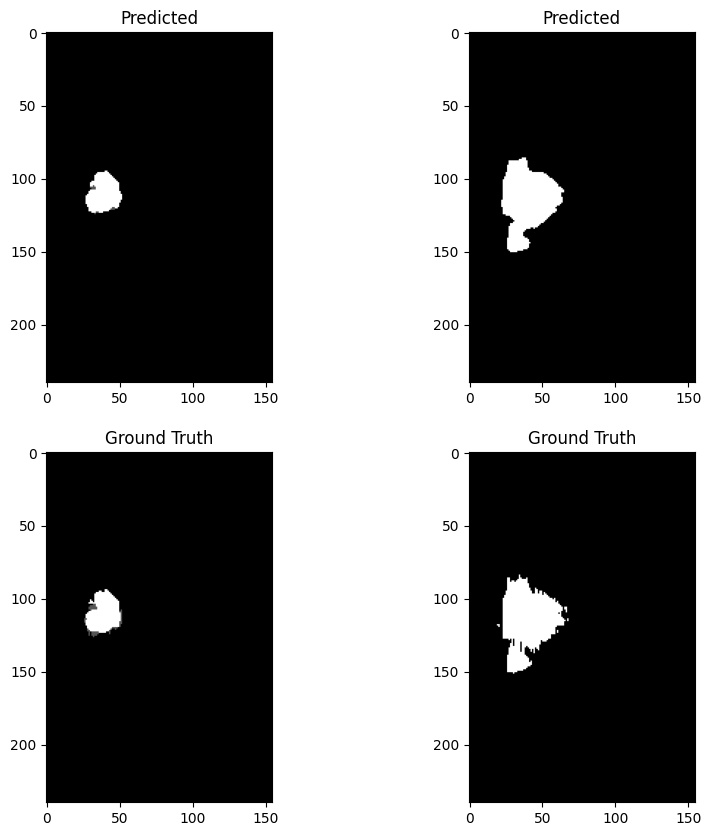

100%|██████████| 118/118 [01:13<00:00,  1.61it/s]


Average Validation Loss: 0.010783034309713264

Average Validation DSC: [0.99883805 0.89393268 0.92248381 0.71679672]
Average Validation ASSD: [ 0.1130956  13.69193911 14.08209818 32.74816718]
Epoch 24/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


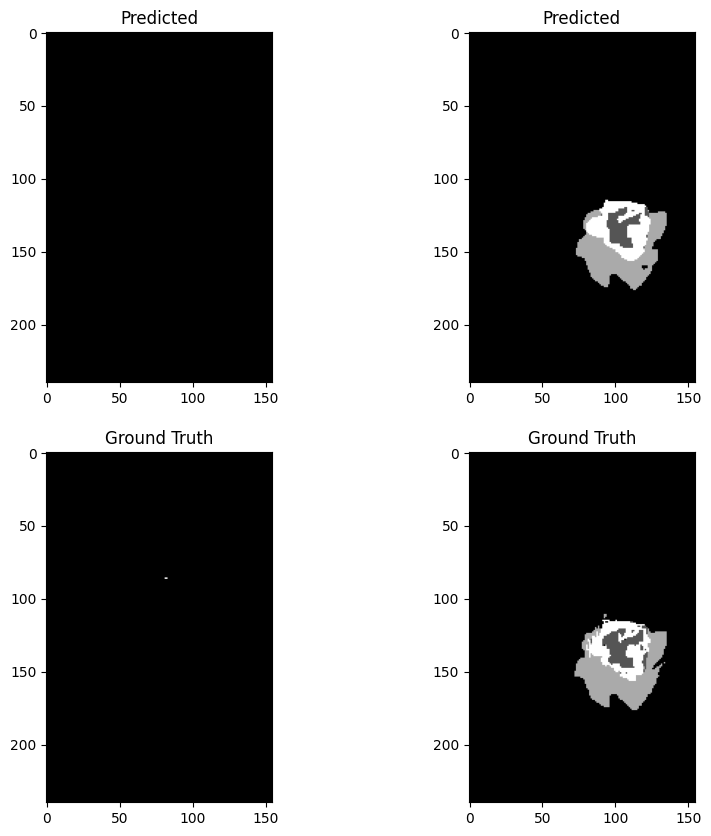

100%|██████████| 472/472 [05:27<00:00,  1.44it/s]



Average Training Loss: 0.0094682566063889

Average Training DSC: [0.99891886 0.90487432 0.92749605 0.74701368]
Average Training ASSD: [ 0.10307248 10.88183054 12.32816112 27.59038962]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


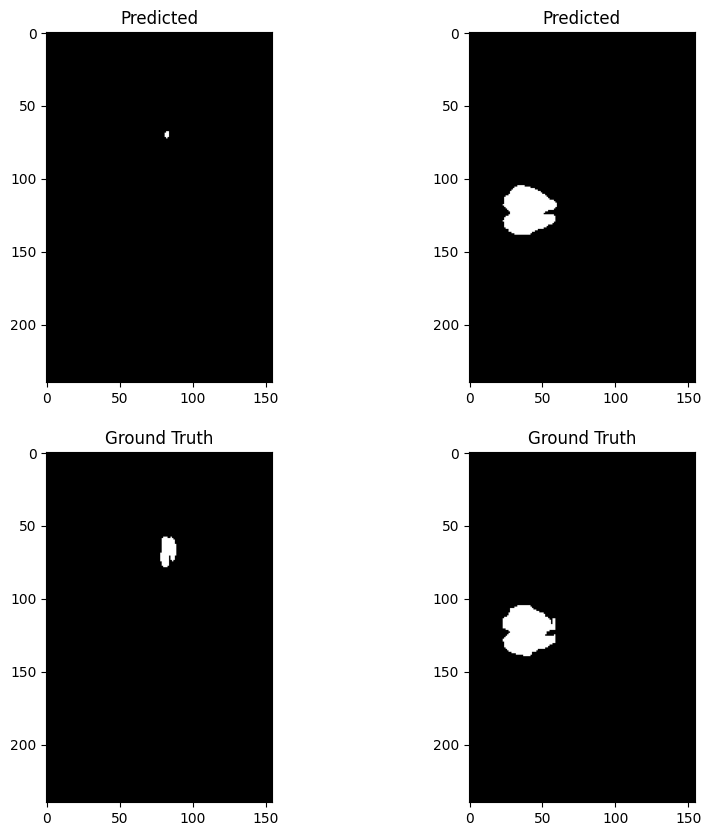

100%|██████████| 118/118 [01:09<00:00,  1.69it/s]


Average Validation Loss: 0.011087450313271355

Average Validation DSC: [0.99882399 0.8966004  0.91550365 0.71254033]
Average Validation ASSD: [ 0.12376466 12.92049516 16.37903871 36.11453993]
Epoch 25/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


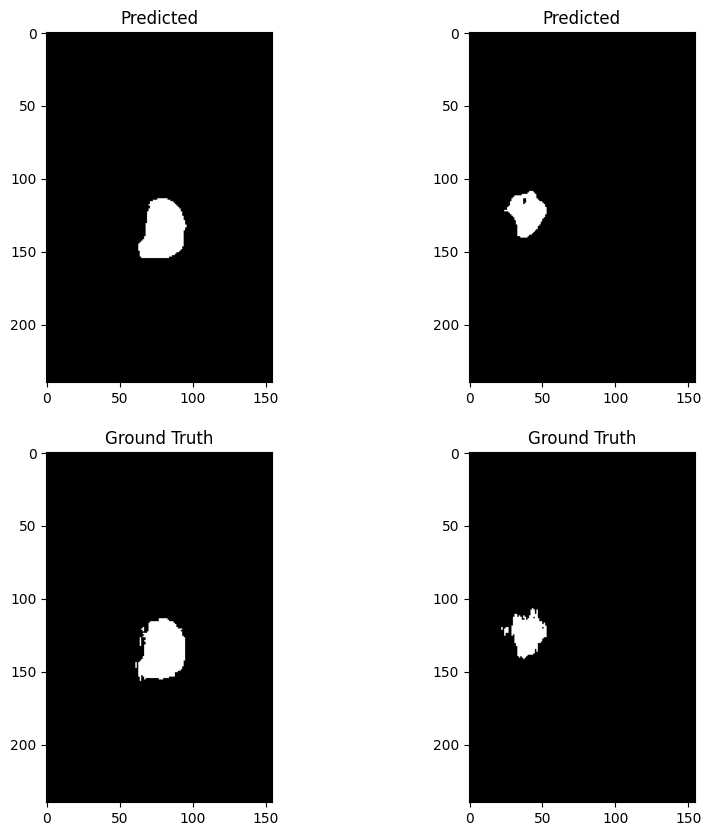

100%|██████████| 472/472 [05:27<00:00,  1.44it/s]



Average Training Loss: 0.008725562192089224

Average Training DSC: [0.99899004 0.91427937 0.93404423 0.75713943]
Average Training ASSD: [ 0.09681172  8.65151299 10.71462006 26.84537708]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


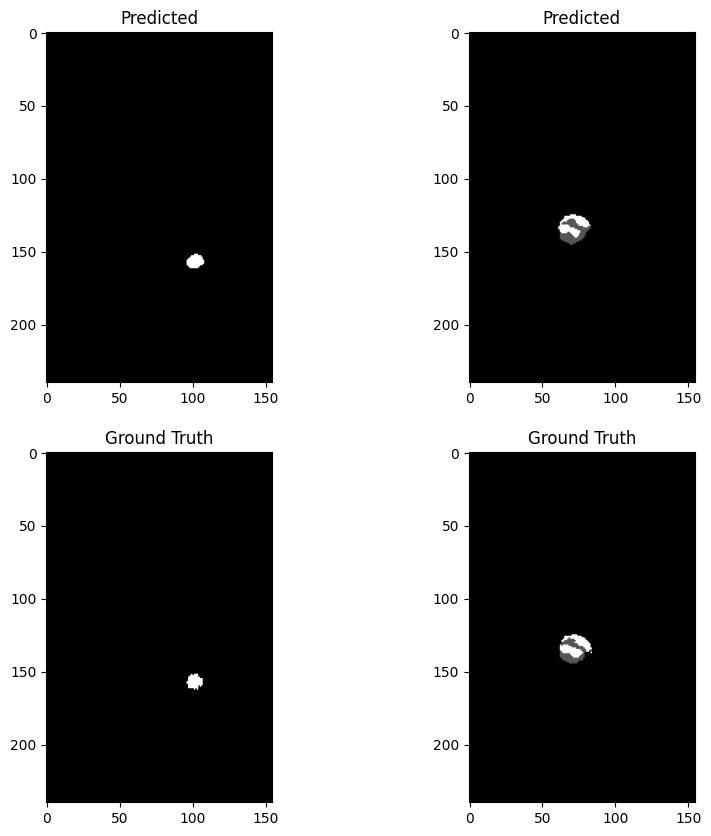

100%|██████████| 118/118 [01:11<00:00,  1.65it/s]


Average Validation Loss: 0.012162935229460313

Average Validation DSC: [0.99879009 0.86250667 0.91265073 0.71730021]
Average Validation ASSD: [ 0.11043742 23.47984911 16.80159073 26.24459915]
Epoch 26/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


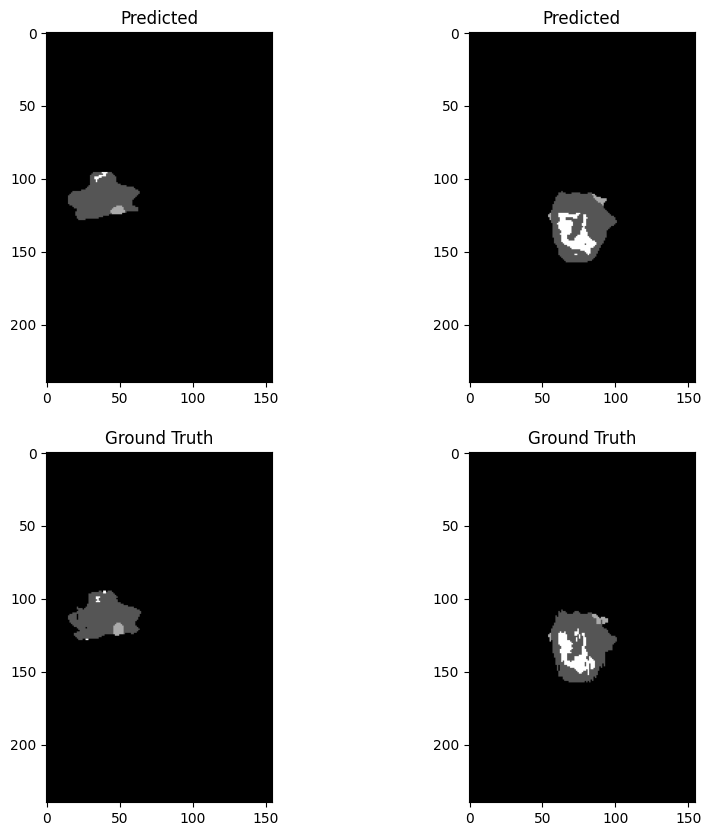

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.009423309982501729

Average Training DSC: [0.99895561 0.90298804 0.93140114 0.75097794]
Average Training ASSD: [ 0.09823465 11.37982008 11.03642416 25.4320105 ]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


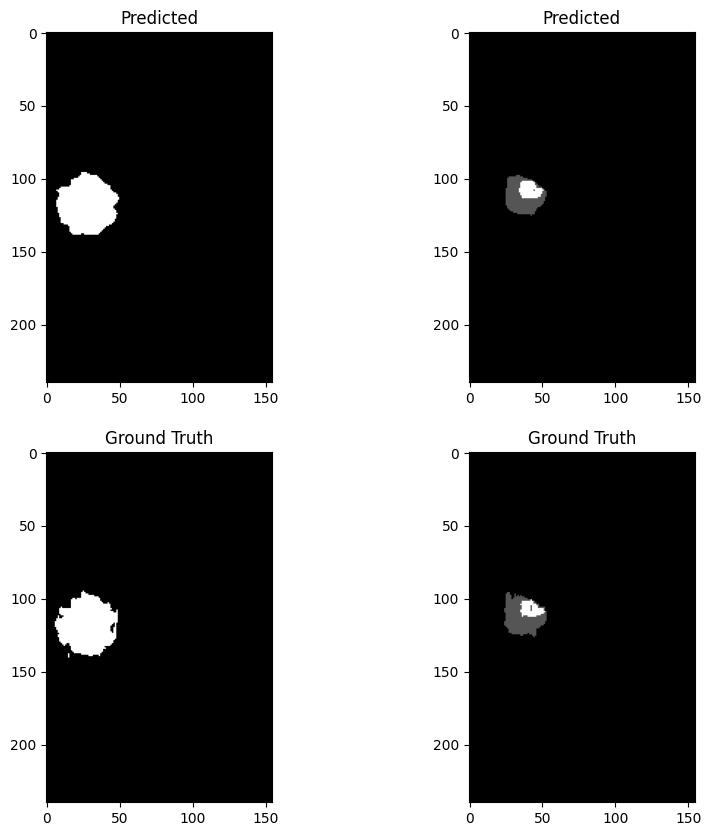

100%|██████████| 118/118 [01:11<00:00,  1.66it/s]


Average Validation Loss: 0.010279132033524624

Average Validation DSC: [0.99889935 0.89881839 0.91909049 0.73797784]
Average Validation ASSD: [ 0.10626409 12.34390925 14.2940006  22.97589666]
Epoch 27/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


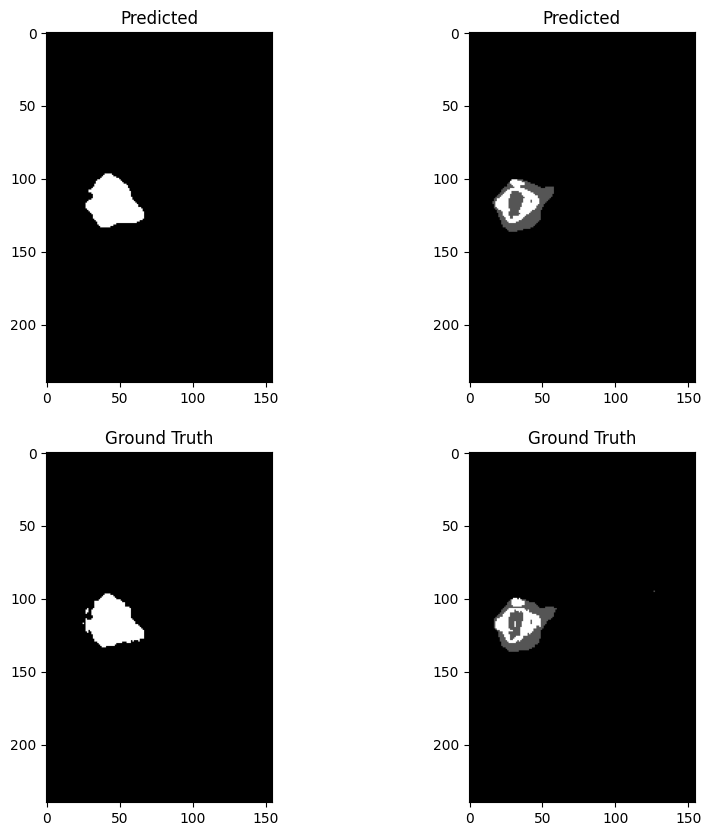

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.008537842993727111

Average Training DSC: [0.9990124  0.91379455 0.93451334 0.76245637]
Average Training ASSD: [ 0.09358344  9.36215319 10.23315131 25.13887111]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


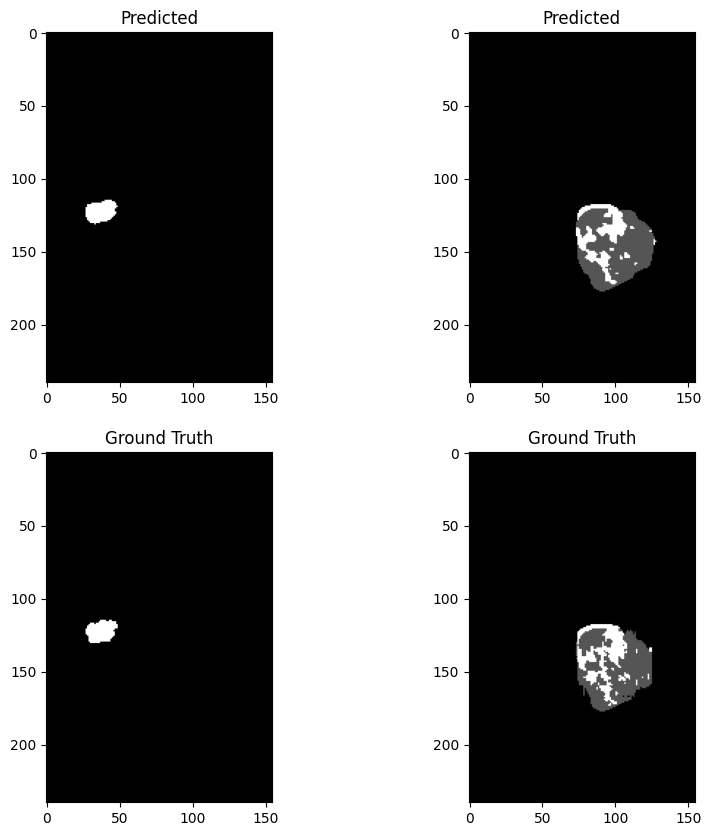

100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Average Validation Loss: 0.010134836283938612

Average Validation DSC: [0.99898305 0.90047092 0.92671072 0.73599866]
Average Validation ASSD: [ 0.09828951 13.6364989  13.24378731 32.1347974 ]
Epoch 28/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


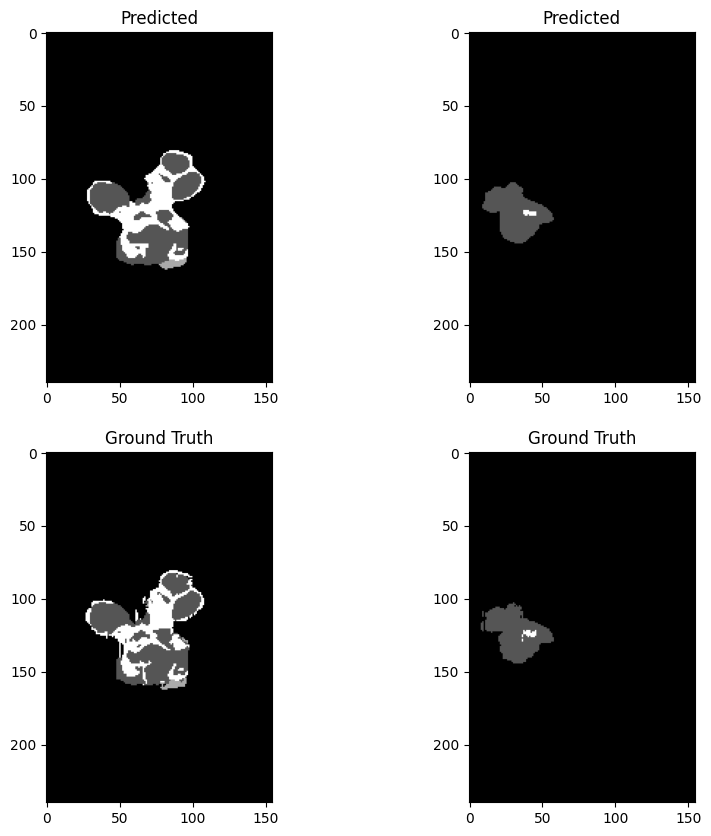

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.008790141897931127

Average Training DSC: [0.99899337 0.91232372 0.93664801 0.76261163]
Average Training ASSD: [ 0.09913451  9.81076695  9.83797298 26.30602127]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


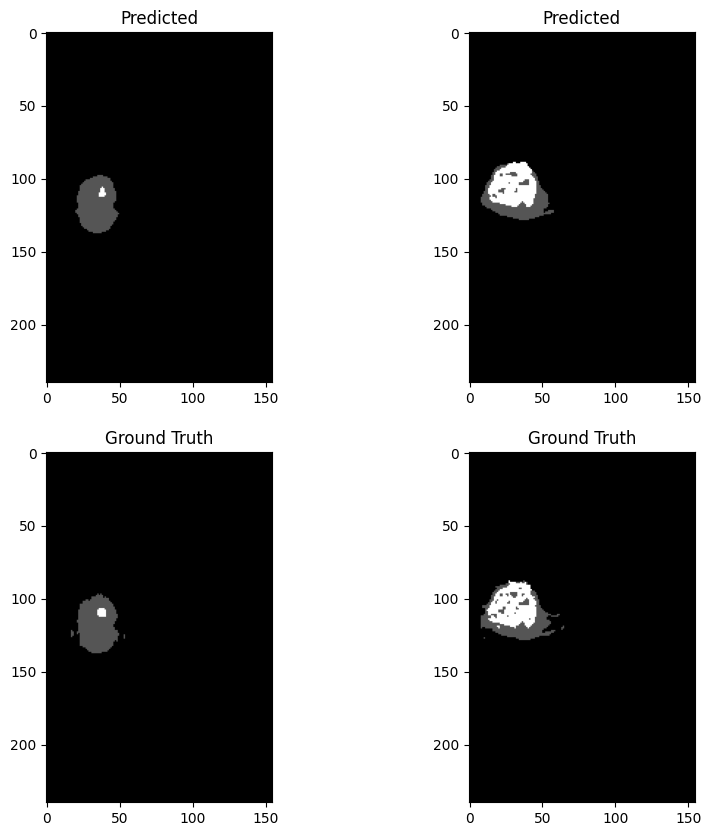

100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Average Validation Loss: 0.01013402673573691

Average Validation DSC: [0.99893367 0.89722448 0.92801312 0.74445441]
Average Validation ASSD: [ 0.10360129 14.0359539  11.74727528 28.09672237]
Epoch 29/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


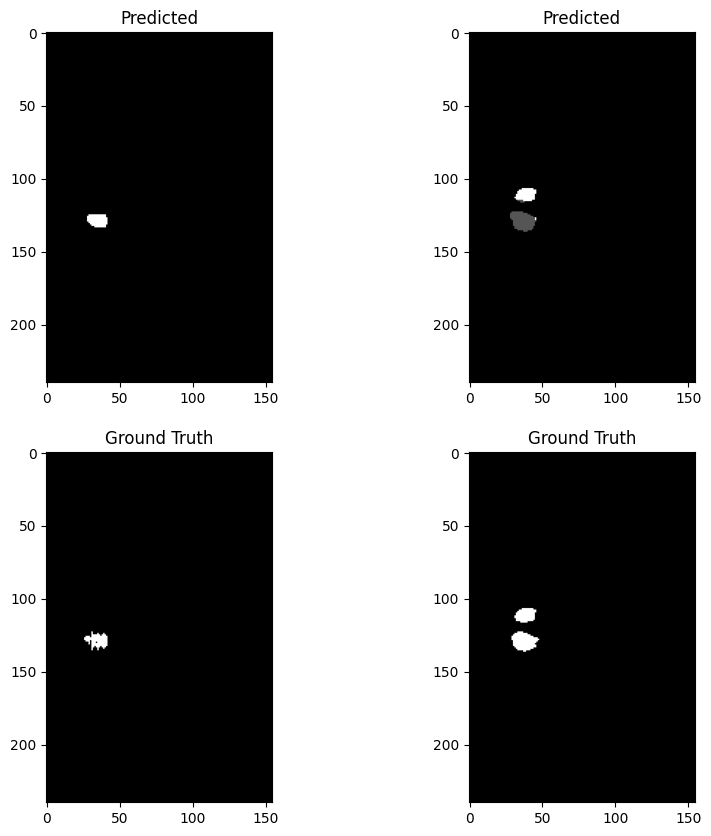

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.008220613557229734

Average Training DSC: [0.9990179  0.91759695 0.94179796 0.77153932]
Average Training ASSD: [ 0.09437367  8.62142346  8.02448023 24.38028995]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


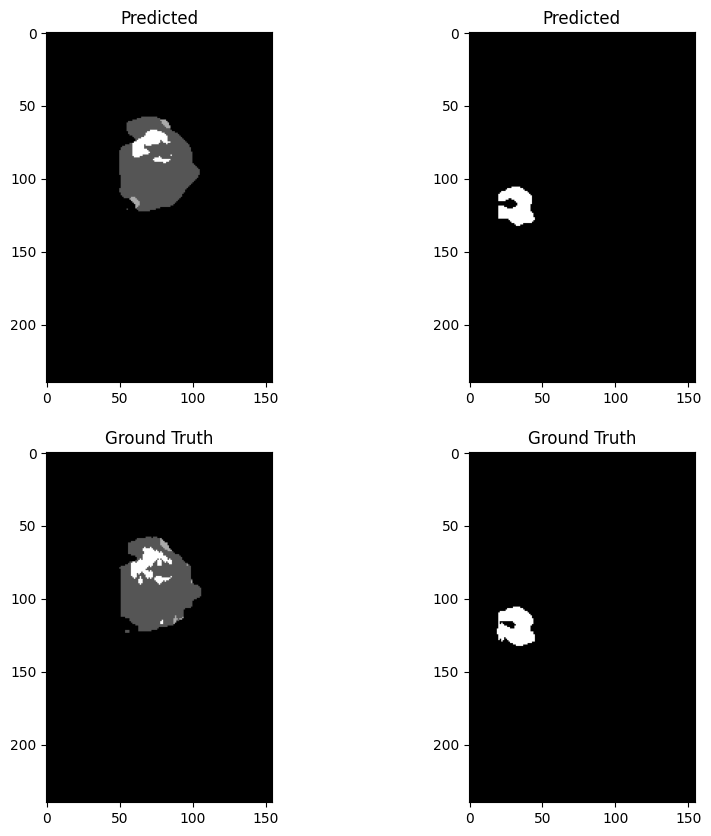

100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Average Validation Loss: 0.00981463598466273

Average Validation DSC: [0.99900425 0.90610802 0.92915323 0.73697708]
Average Validation ASSD: [ 0.09956947 12.28459691 12.10491625 31.73128634]
Epoch 30/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


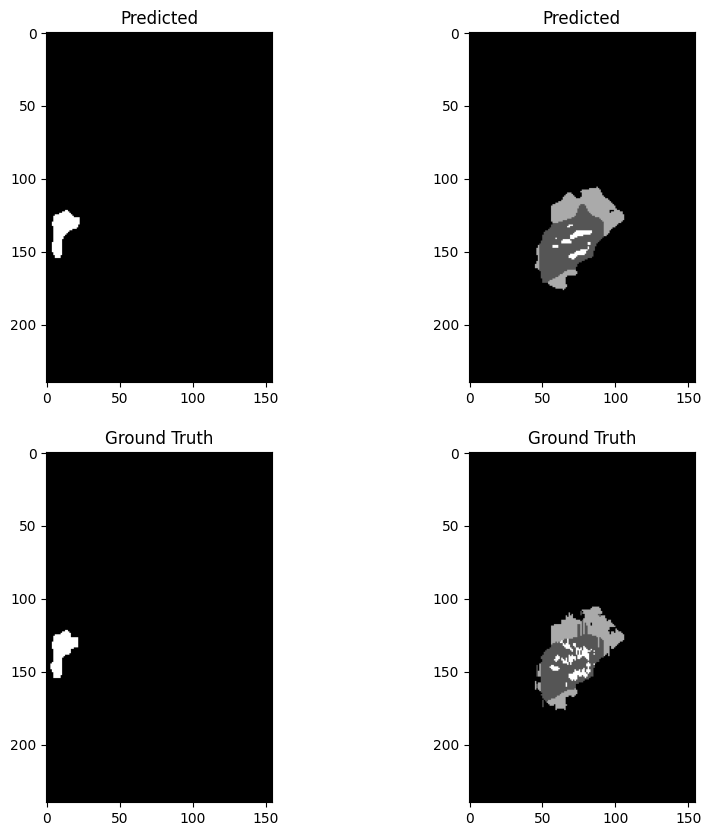

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.0078034807081429

Average Training DSC: [0.99911064 0.91988315 0.94120957 0.77975002]
Average Training ASSD: [ 0.08331987  8.5775153   8.9092408  23.96654629]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


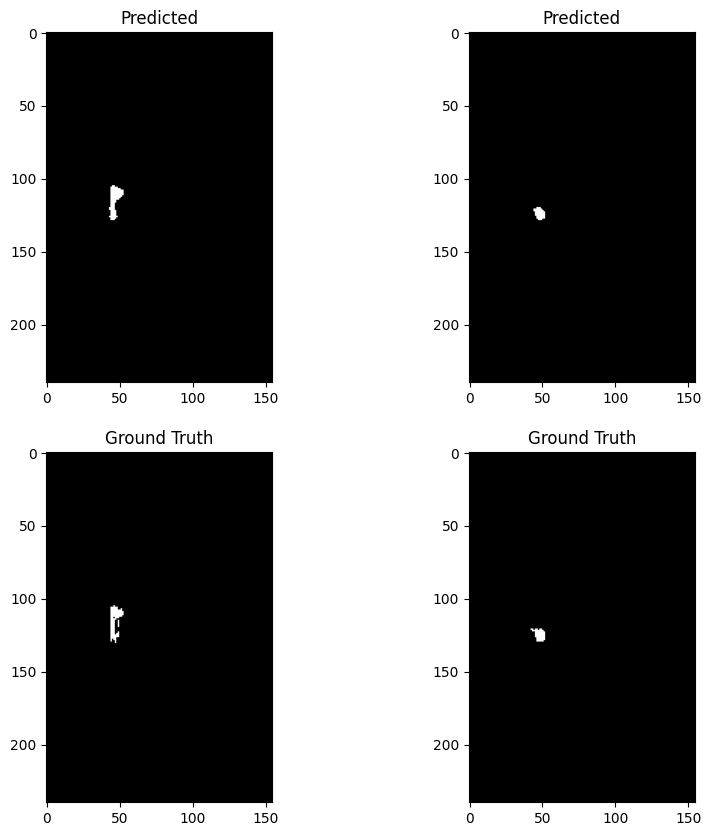

100%|██████████| 118/118 [01:11<00:00,  1.66it/s]


Average Validation Loss: 0.009754833283881515

Average Validation DSC: [0.99902606 0.90112074 0.92633237 0.74828748]
Average Validation ASSD: [ 0.09461513 14.00763773 13.10383631 27.19578064]
Epoch 31/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


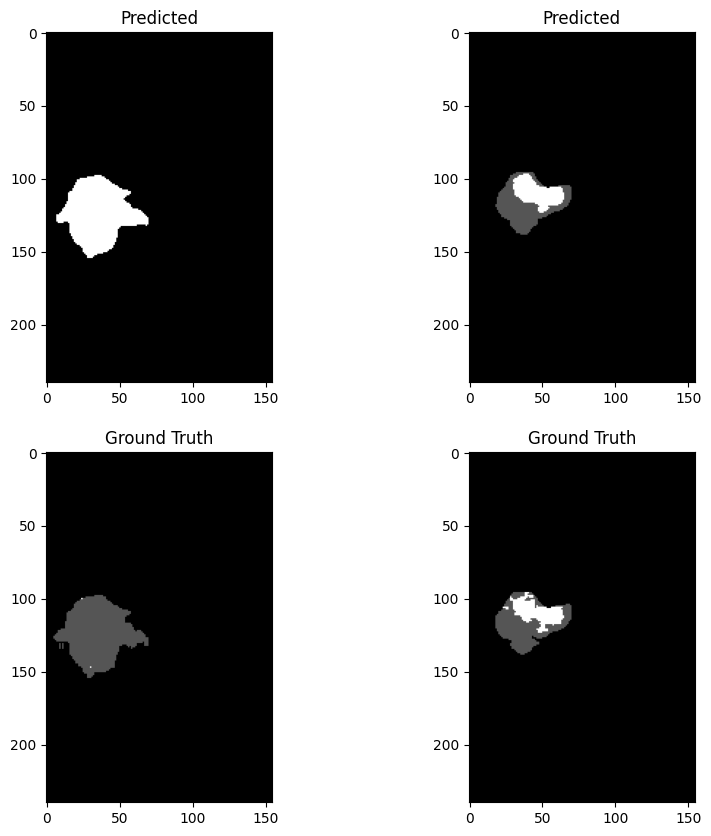

100%|██████████| 472/472 [05:28<00:00,  1.44it/s]



Average Training Loss: 0.0074437325361571514

Average Training DSC: [0.99915565 0.92703686 0.94110204 0.78719026]
Average Training ASSD: [ 0.07836448  6.96015188  9.07497948 23.66151715]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


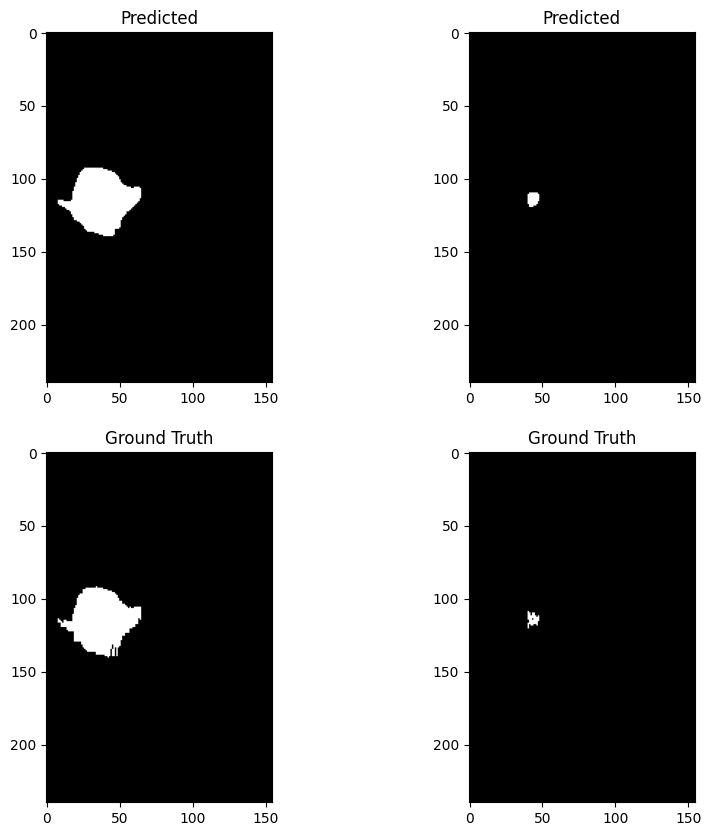

100%|██████████| 118/118 [01:10<00:00,  1.66it/s]


Average Validation Loss: 0.009289922090089423

Average Validation DSC: [0.99910019 0.9070004  0.93382054 0.75976648]
Average Validation ASSD: [ 0.08883042 13.21039545 11.69105044 28.05172405]
Epoch 32/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


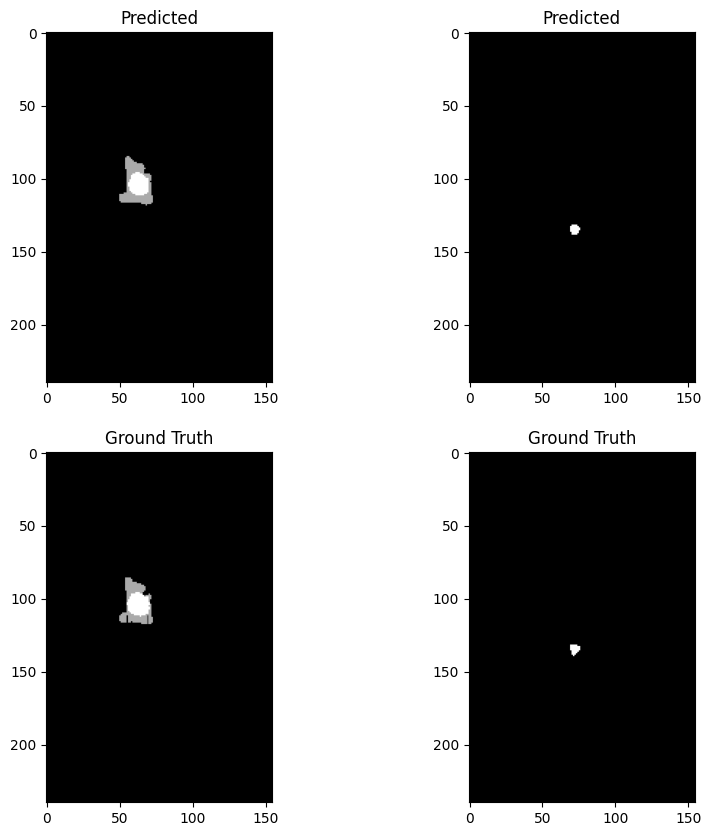

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.006947588759584952

Average Training DSC: [0.99919761 0.93143046 0.94316084 0.79613293]
Average Training ASSD: [ 0.07420495  6.66067573  8.51184696 23.68110242]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


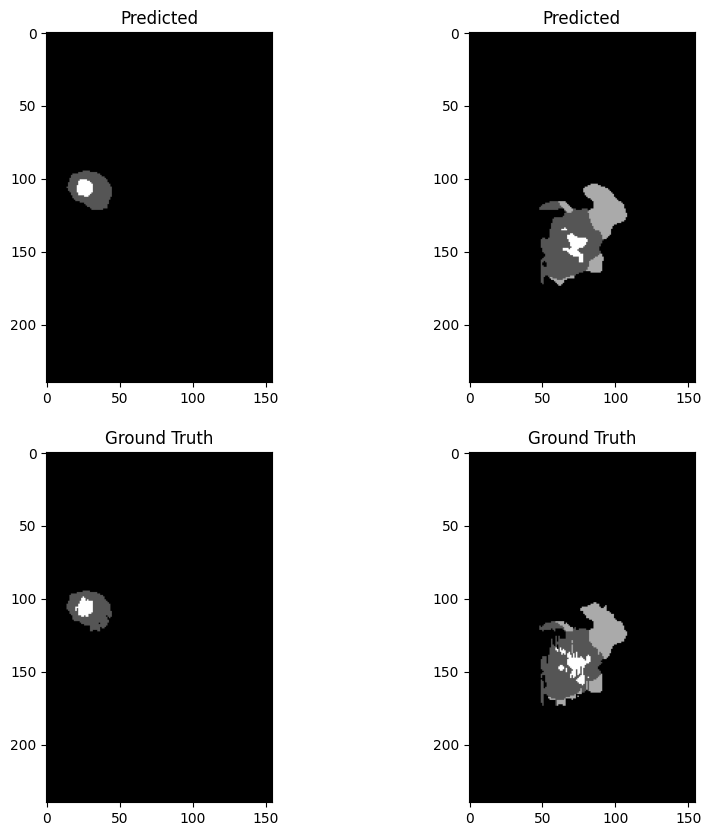

100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Average Validation Loss: 0.009395801606272363

Average Validation DSC: [0.99908525 0.91197771 0.93422134 0.75244718]
Average Validation ASSD: [ 0.08828032 11.67604141 10.36051764 28.95027442]
Epoch 33/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


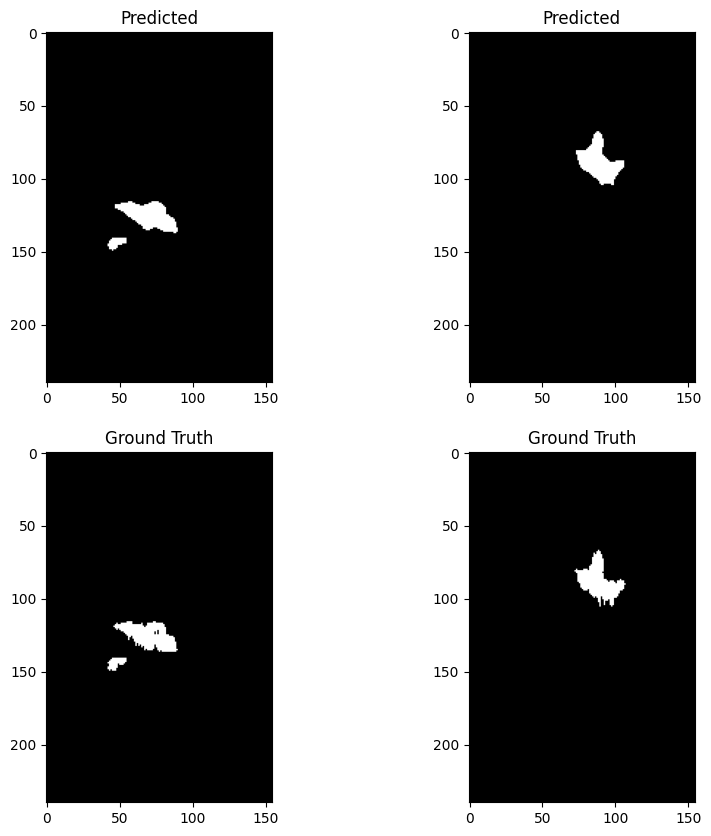

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.006802555239735708

Average Training DSC: [0.99920392 0.9335565  0.9456664  0.79669741]
Average Training ASSD: [ 0.07511465  5.68799879  8.31017507 23.0828793 ]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


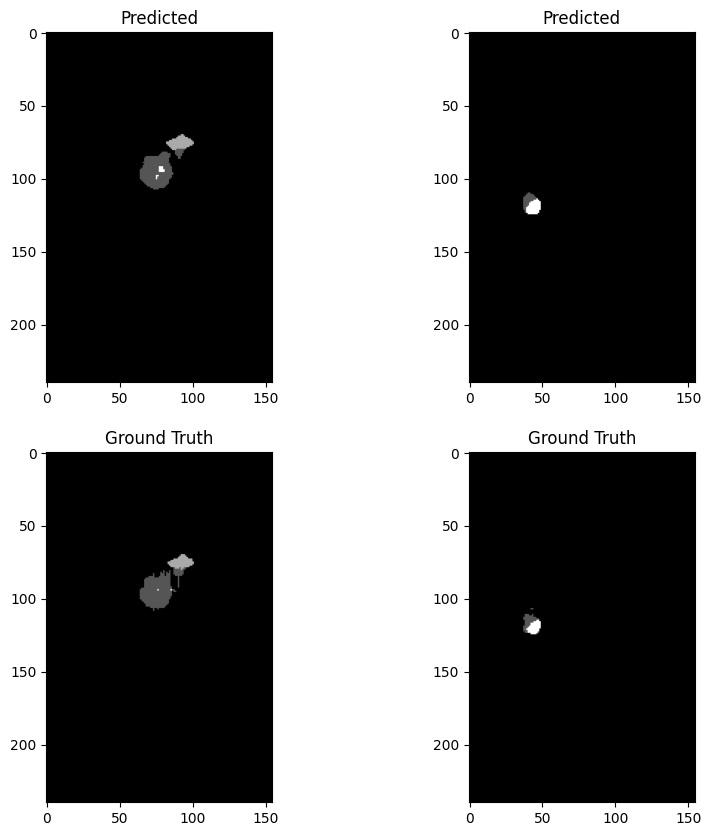

100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Average Validation Loss: 0.010094274687817541

Average Validation DSC: [0.99904234 0.90943629 0.91998076 0.75462747]
Average Validation ASSD: [ 0.0956304   9.40500779 14.25805849 24.65822168]
Epoch 34/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


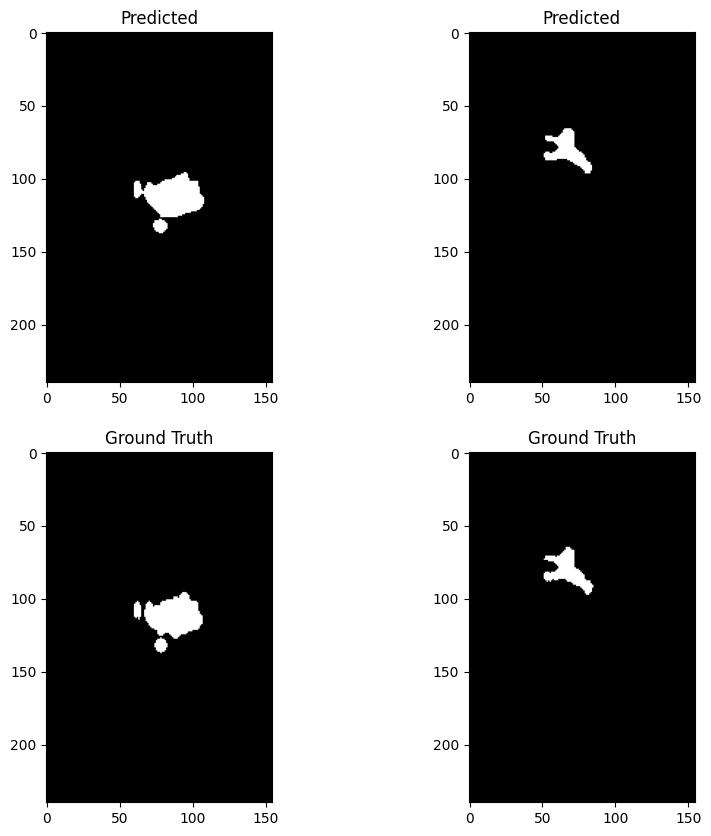

100%|██████████| 472/472 [05:31<00:00,  1.42it/s]



Average Training Loss: 0.007391473363741632

Average Training DSC: [0.99915174 0.92394017 0.94117883 0.79196605]
Average Training ASSD: [ 0.07977879  8.34057502  9.20694968 22.27712519]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


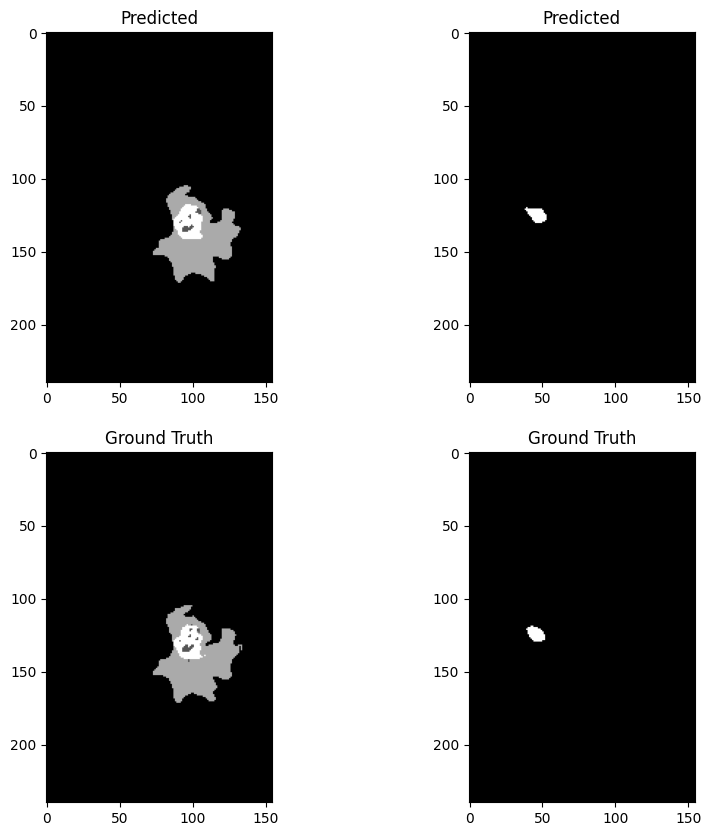

100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Average Validation Loss: 0.009801087391925818

Average Validation DSC: [0.99898024 0.90348045 0.93099028 0.74329397]
Average Validation ASSD: [ 0.10538602 11.90112875 10.59062268 30.52104897]
Epoch 35/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


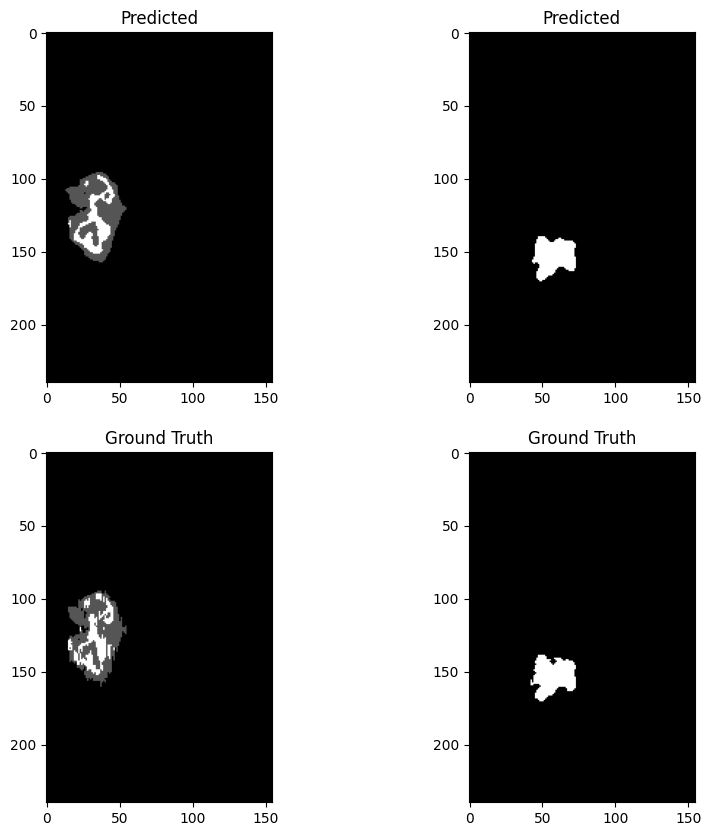

100%|██████████| 472/472 [05:31<00:00,  1.42it/s]



Average Training Loss: 0.006628808666067987

Average Training DSC: [0.99922017 0.93176291 0.94644228 0.8022276 ]
Average Training ASSD: [ 0.07327765  7.25524969  8.56744517 23.35628957]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


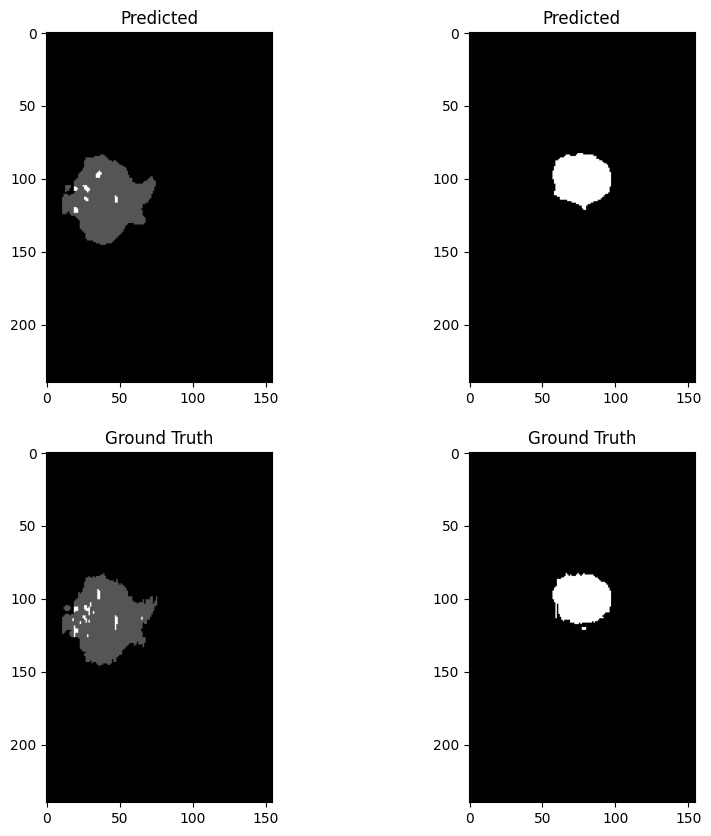

100%|██████████| 118/118 [01:11<00:00,  1.65it/s]


Average Validation Loss: 0.008654266420230901

Average Validation DSC: [0.999138   0.91828897 0.9387051  0.77675838]
Average Validation ASSD: [ 0.08103925  9.91765738  9.97887129 24.5209805 ]
Epoch 36/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


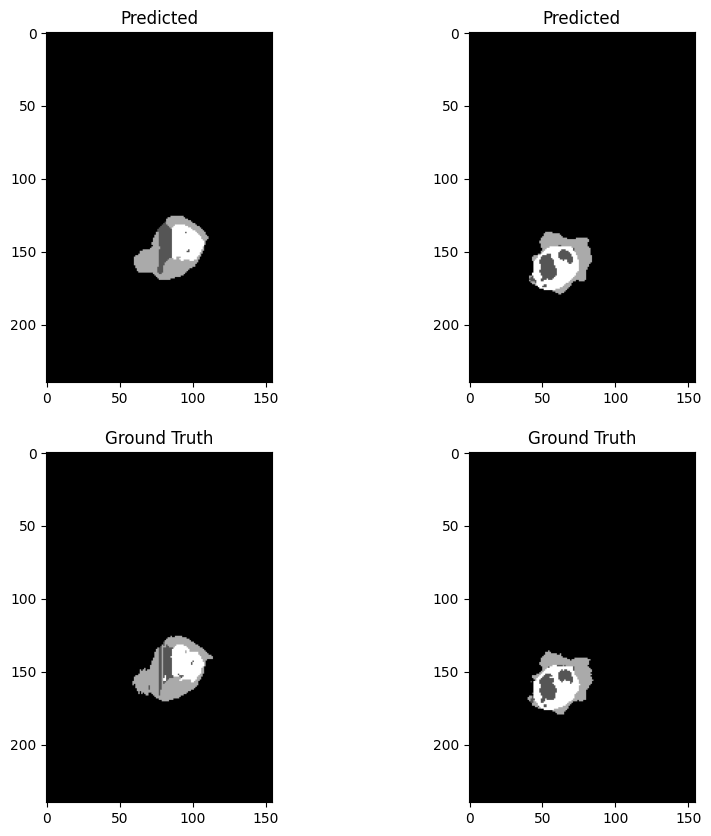

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.006182829097161954

Average Training DSC: [0.99928238 0.93808357 0.95135828 0.8129638 ]
Average Training ASSD: [ 0.06564194  5.4947749   7.11277727 21.14287762]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


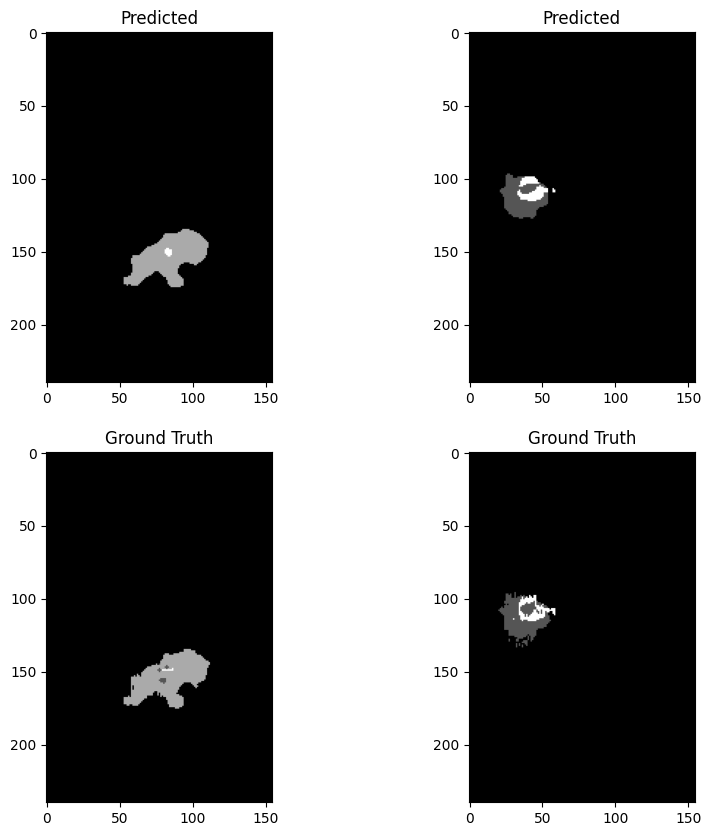

100%|██████████| 118/118 [01:09<00:00,  1.69it/s]


Average Validation Loss: 0.008740687166672137

Average Validation DSC: [0.99913017 0.92064766 0.93891225 0.76320014]
Average Validation ASSD: [ 0.09072581  9.3384543  10.13461466 29.63117254]
Epoch 37/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


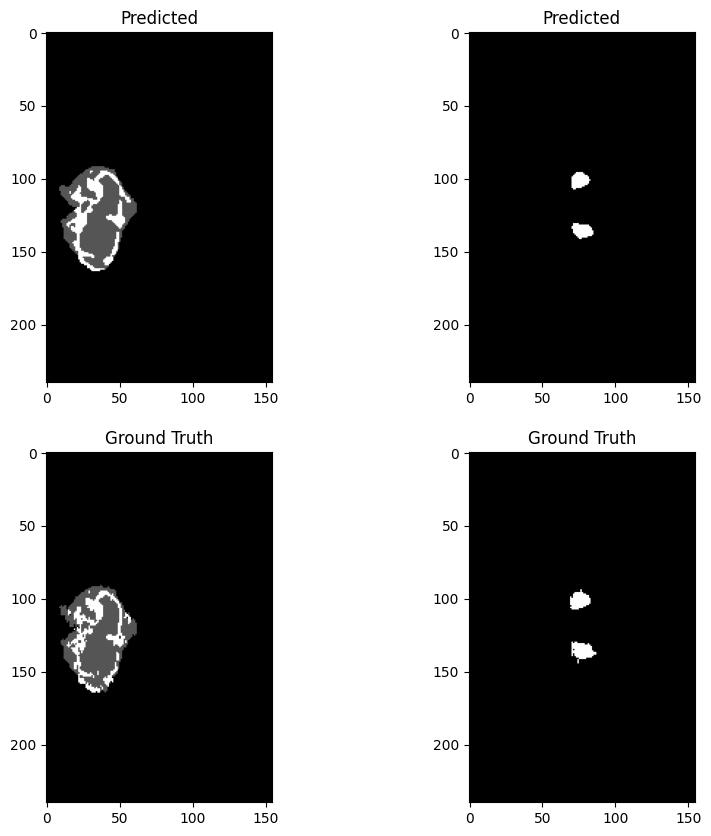

100%|██████████| 472/472 [05:30<00:00,  1.43it/s]



Average Training Loss: 0.007000147199783064

Average Training DSC: [0.99921026 0.92588309 0.9434233  0.80104538]
Average Training ASSD: [ 0.07441134  8.14610231  9.24746741 19.78628407]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


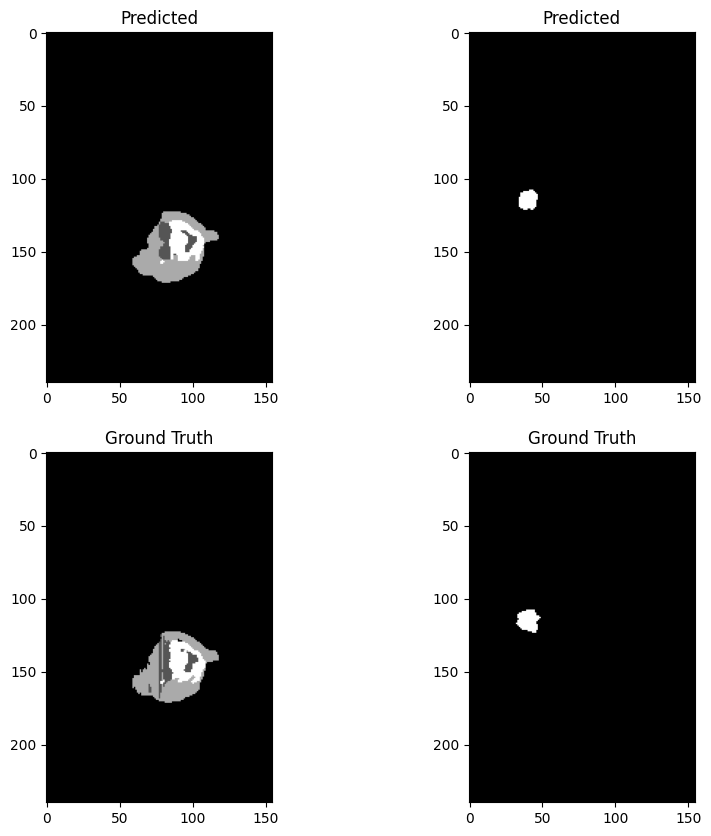

100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Average Validation Loss: 0.009967983175479507

Average Validation DSC: [0.99897363 0.90347804 0.93388829 0.75280701]
Average Validation ASSD: [ 0.09946641 13.22244499 11.87897913 25.7666517 ]
Epoch 38/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


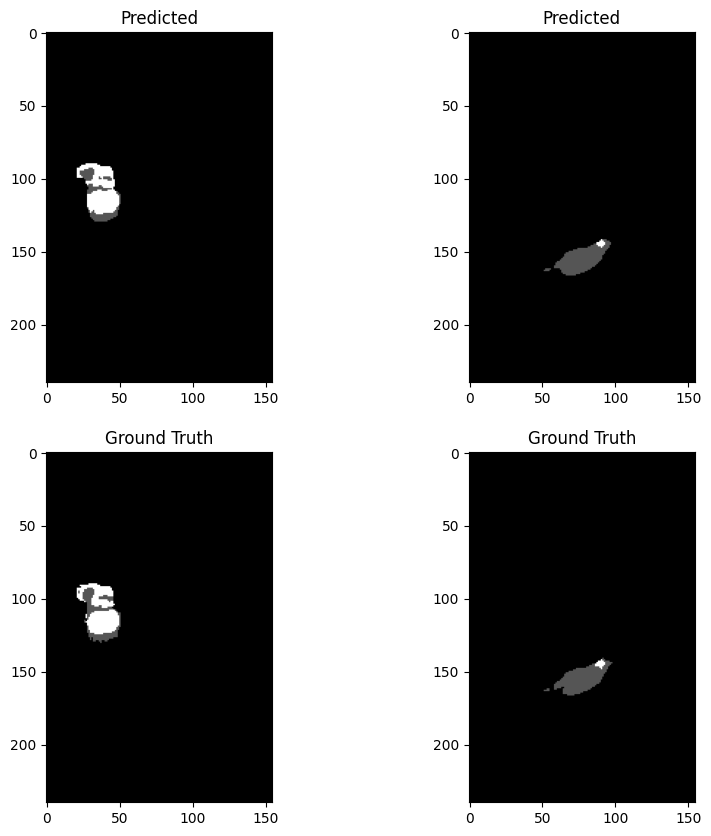

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.006876154248780271

Average Training DSC: [0.99920429 0.92994012 0.94551107 0.80286464]
Average Training ASSD: [ 0.0768323   7.63769061  8.74028133 21.09369878]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


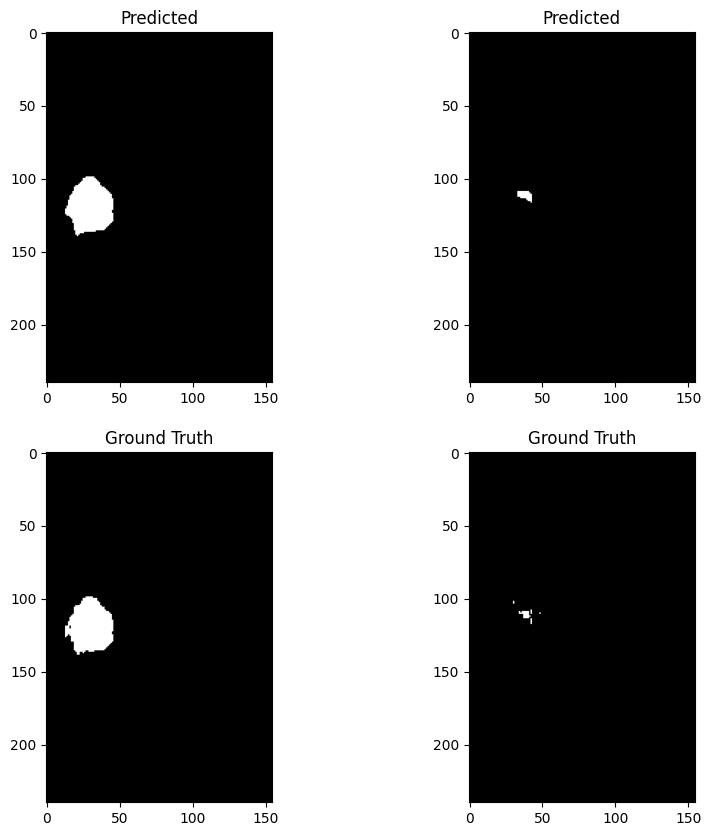

100%|██████████| 118/118 [01:11<00:00,  1.66it/s]


Average Validation Loss: 0.008908841155185285

Average Validation DSC: [0.99909973 0.91641489 0.93428834 0.75224874]
Average Validation ASSD: [ 0.08633026  9.94619935 11.77908208 24.03827693]
Epoch 39/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


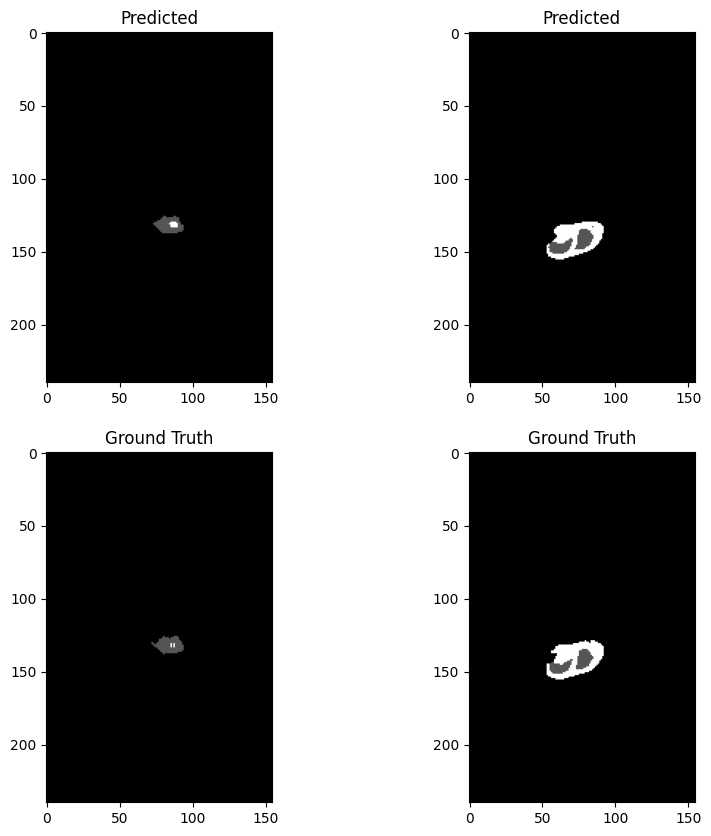

100%|██████████| 472/472 [05:29<00:00,  1.43it/s]



Average Training Loss: 0.00578177219821077

Average Training DSC: [0.99932846 0.94049432 0.95304405 0.81973846]
Average Training ASSD: [ 0.0623239   5.59285324  7.74324746 21.05383965]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


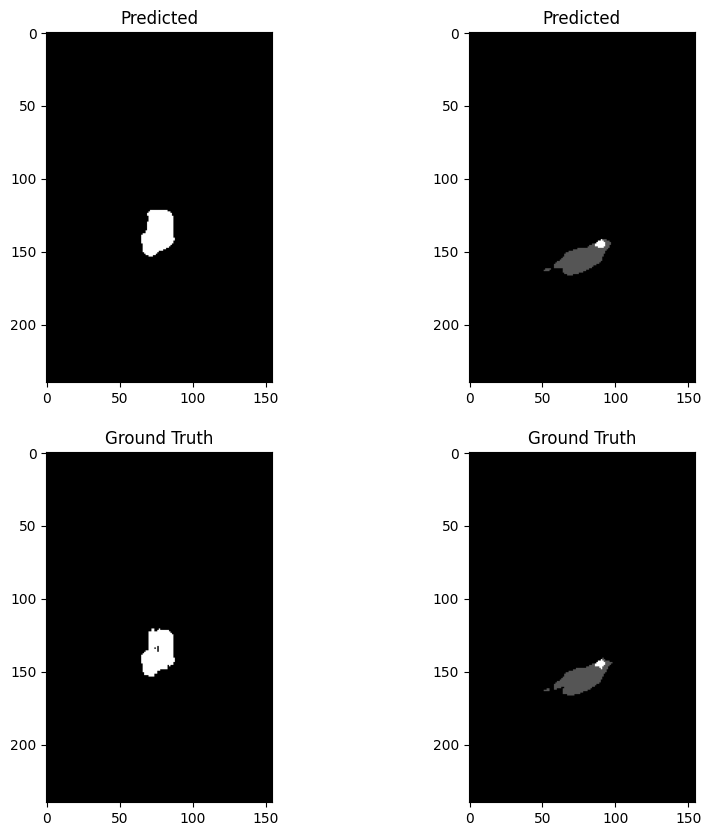

100%|██████████| 118/118 [01:12<00:00,  1.62it/s]


Average Validation Loss: 0.00805879660913626

Average Validation DSC: [0.99923239 0.92623075 0.94370506 0.78838947]
Average Validation ASSD: [ 0.07450217  8.54459194  9.35590328 22.67019713]
Epoch 40/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


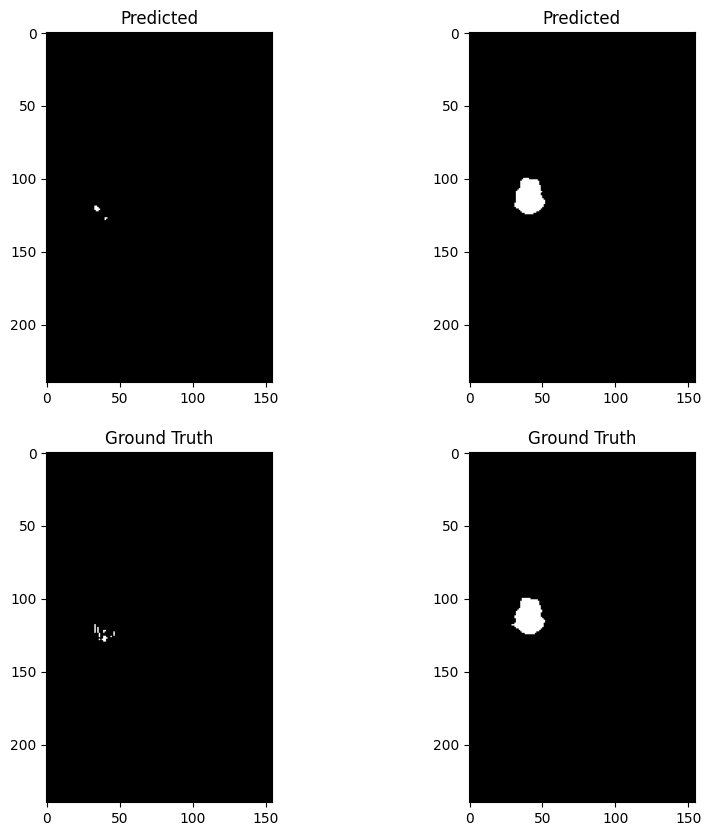

100%|██████████| 472/472 [05:30<00:00,  1.43it/s]



Average Training Loss: 0.005660964632347636

Average Training DSC: [0.99934266 0.94451577 0.95435537 0.82650955]
Average Training ASSD: [ 0.06030397  4.57409201  7.05222485 19.86296425]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


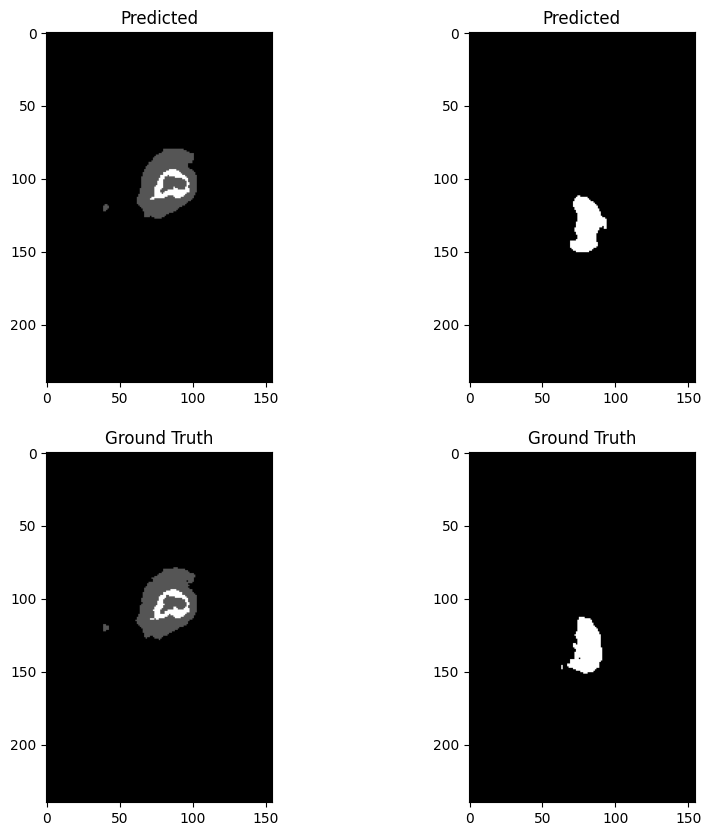

100%|██████████| 118/118 [01:11<00:00,  1.64it/s]


Average Validation Loss: 0.008595873386662263

Average Validation DSC: [0.99919424 0.9240499  0.94028427 0.7797494 ]
Average Validation ASSD: [ 0.07847132  8.55685121  9.74774809 26.14066512]
Epoch 41/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


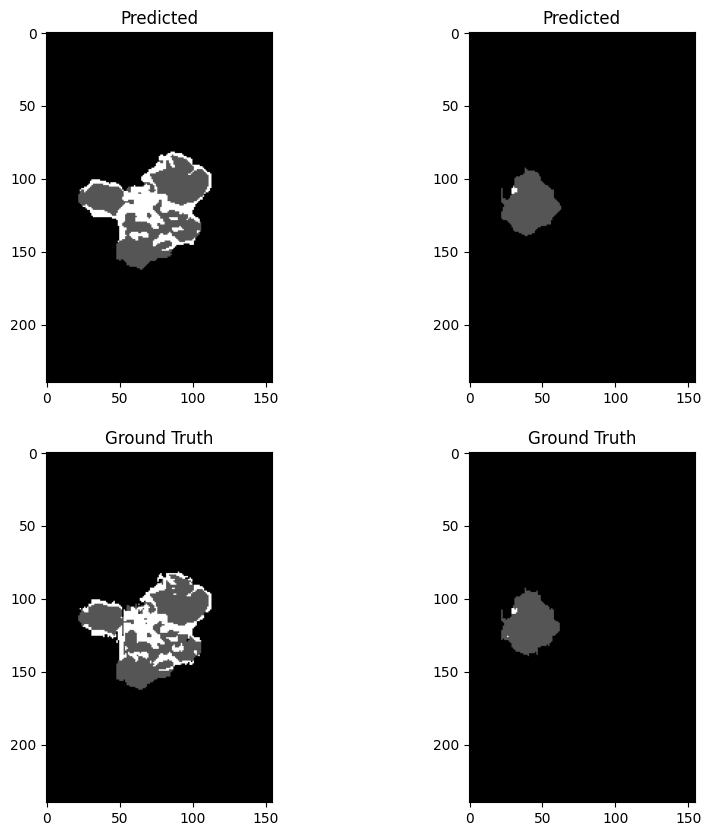

100%|██████████| 472/472 [05:31<00:00,  1.42it/s]



Average Training Loss: 0.005602410443963767

Average Training DSC: [0.99934643 0.94499072 0.95513454 0.82817157]
Average Training ASSD: [ 0.05892183  4.38257114  6.9084337  19.33466836]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


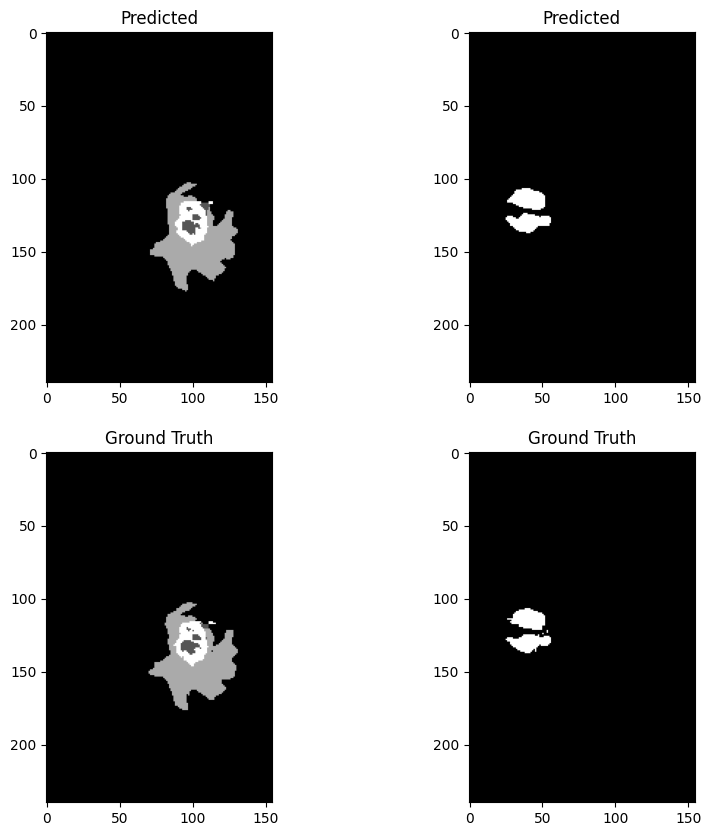

100%|██████████| 118/118 [01:10<00:00,  1.66it/s]


Average Validation Loss: 0.007856300625539684

Average Validation DSC: [0.99924592 0.92701795 0.94249473 0.79402147]
Average Validation ASSD: [ 0.07140958  7.97468812 10.30807606 20.83449103]
Epoch 42/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


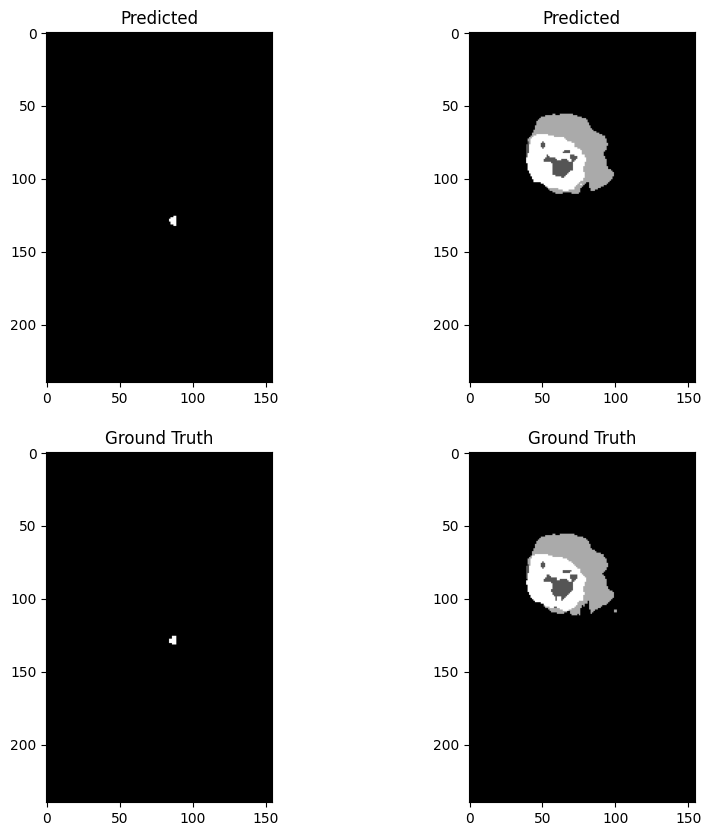

100%|██████████| 472/472 [05:32<00:00,  1.42it/s]



Average Training Loss: 0.006556596874330445

Average Training DSC: [0.99923942 0.93073251 0.9468323  0.81339734]
Average Training ASSD: [ 0.07080009  7.78723256  8.71338168 19.59436091]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


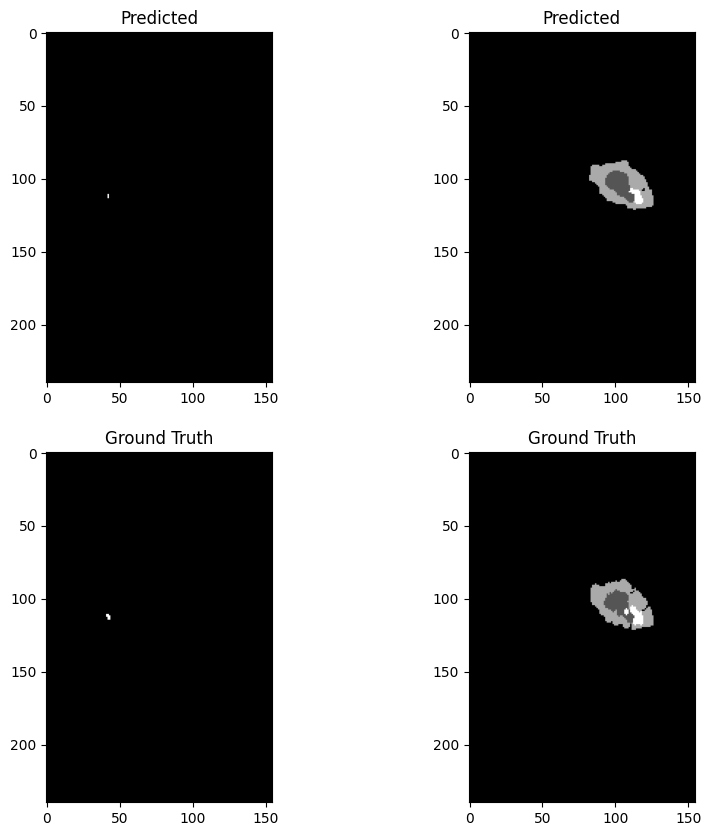

100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Average Validation Loss: 0.009296710180686944

Average Validation DSC: [0.99910382 0.90867151 0.93763575 0.77944849]
Average Validation ASSD: [ 0.08357882 11.67482195 11.6884438  20.64704705]
Epoch 43/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


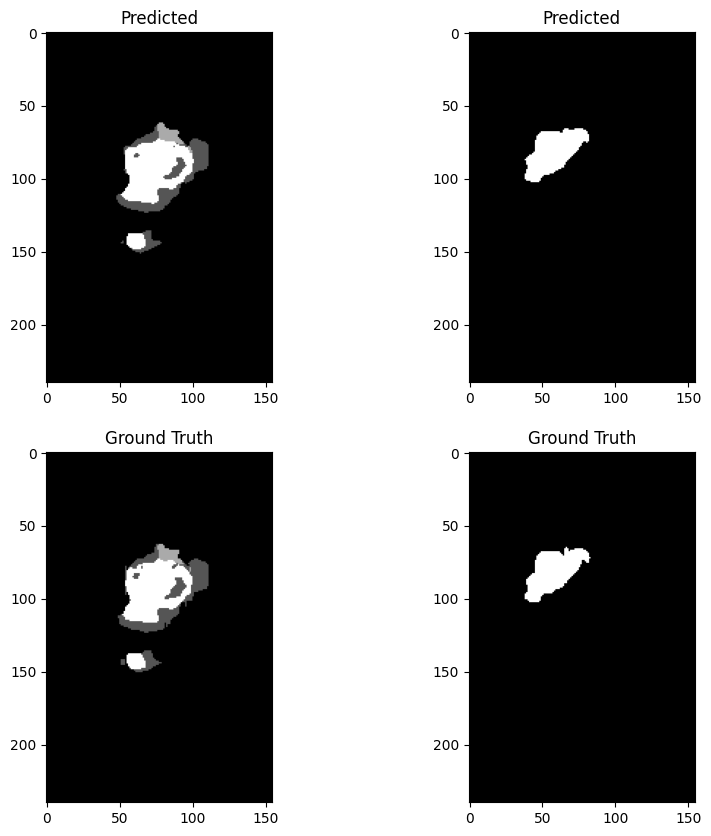

100%|██████████| 472/472 [05:30<00:00,  1.43it/s]



Average Training Loss: 0.006452742484062753

Average Training DSC: [0.99930033 0.93014093 0.94497348 0.8175549 ]
Average Training ASSD: [ 0.06563831  8.4818317   9.79014789 18.7975812 ]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


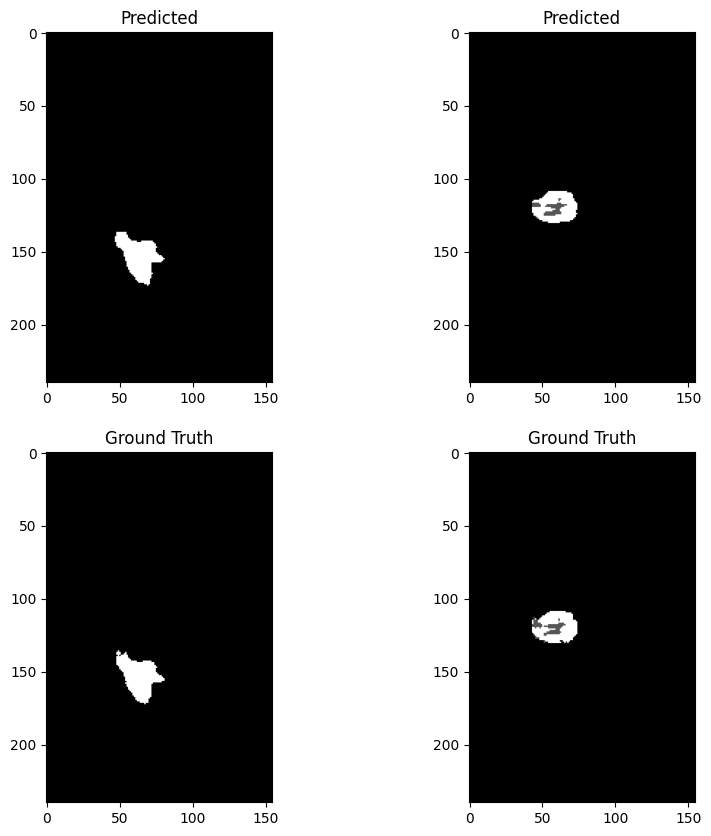

100%|██████████| 118/118 [01:11<00:00,  1.65it/s]


Average Validation Loss: 0.008574925398580352

Average Validation DSC: [0.99917109 0.91140343 0.92670856 0.77356562]
Average Validation ASSD: [ 0.08090181 12.03299791 13.60287914 18.91604937]
Epoch 44/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


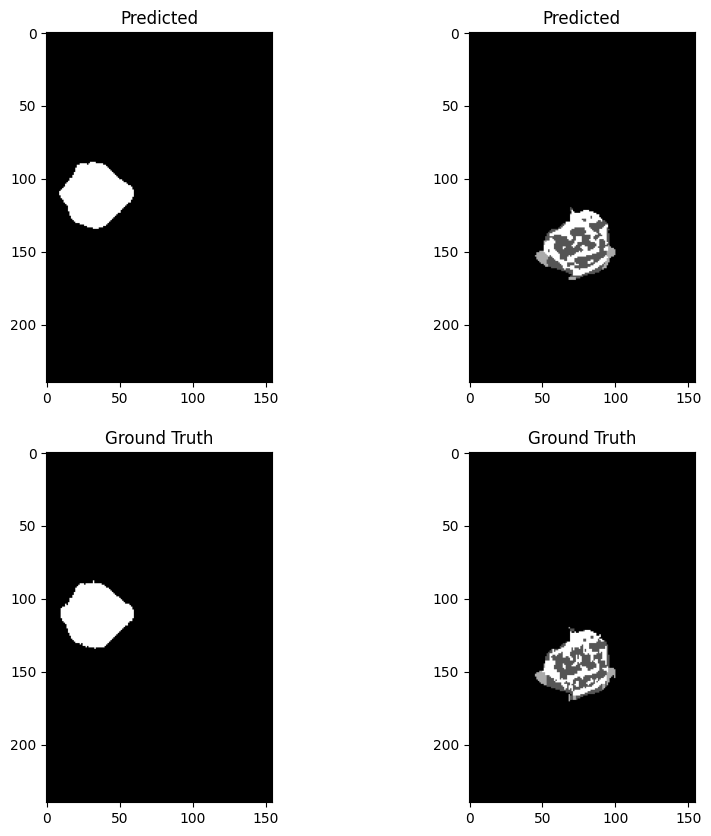

100%|██████████| 472/472 [05:34<00:00,  1.41it/s]



Average Training Loss: 0.005502659419030583

Average Training DSC: [0.99937393 0.94709552 0.95386374 0.82929491]
Average Training ASSD: [ 0.05932443  4.03803833  7.29582886 19.38081656]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


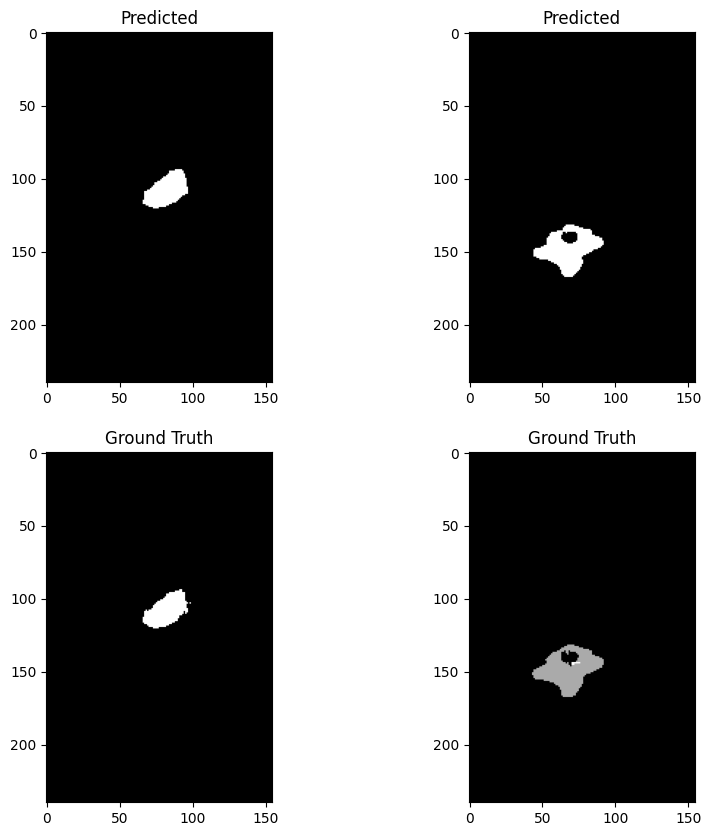

100%|██████████| 118/118 [01:10<00:00,  1.66it/s]


Average Validation Loss: 0.00821394122489807

Average Validation DSC: [0.99920714 0.92369785 0.92699535 0.78479736]
Average Validation ASSD: [ 0.07765887  9.89167854 14.54769251 23.04810658]
Epoch 45/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


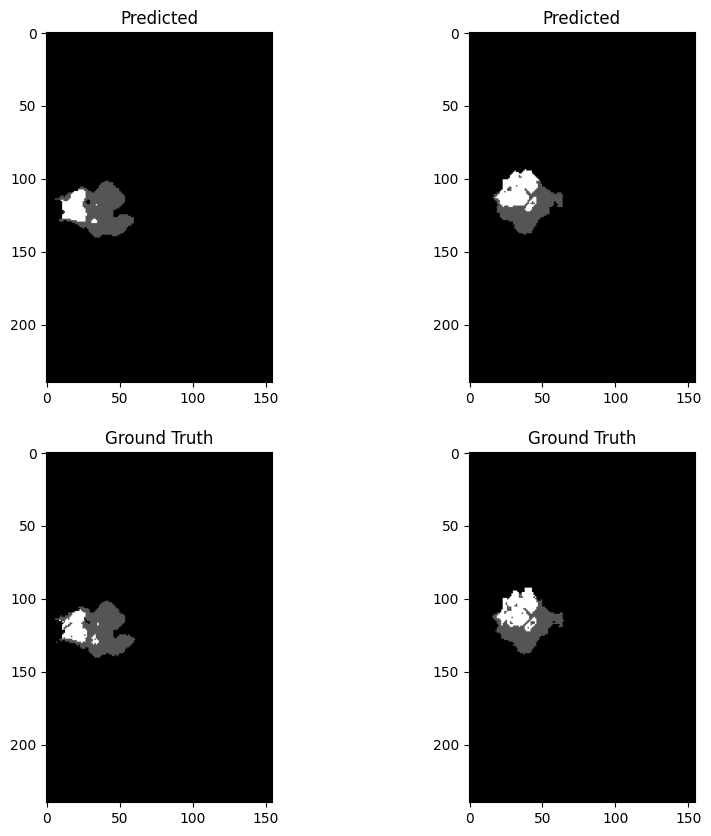

100%|██████████| 472/472 [05:35<00:00,  1.41it/s]



Average Training Loss: 0.00516028722631745

Average Training DSC: [0.99940311 0.94866926 0.95834677 0.8375803 ]
Average Training ASSD: [ 0.05645812  4.54859993  6.46995541 18.09856433]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


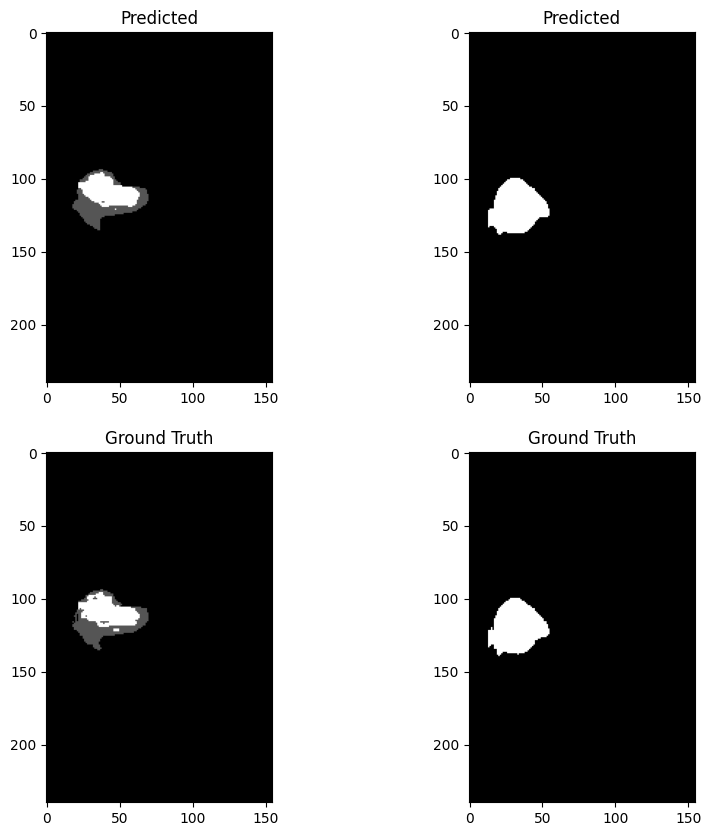

100%|██████████| 118/118 [01:11<00:00,  1.65it/s]


Average Validation Loss: 0.007697787988236395

Average Validation DSC: [0.99929486 0.92906239 0.94630192 0.79834407]
Average Validation ASSD: [ 0.06865721  9.46784578  9.52731402 22.80968799]
Epoch 46/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


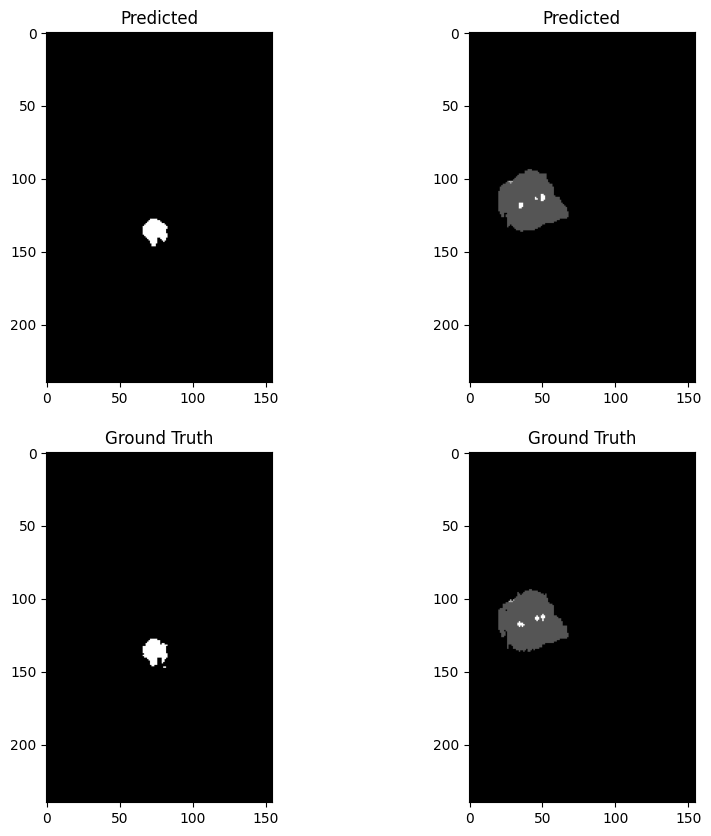

100%|██████████| 472/472 [05:34<00:00,  1.41it/s]



Average Training Loss: 0.004668199598801054

Average Training DSC: [0.99945924 0.95398091 0.96101312 0.84916107]
Average Training ASSD: [ 0.04836765  3.39679988  5.98082149 16.99721859]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


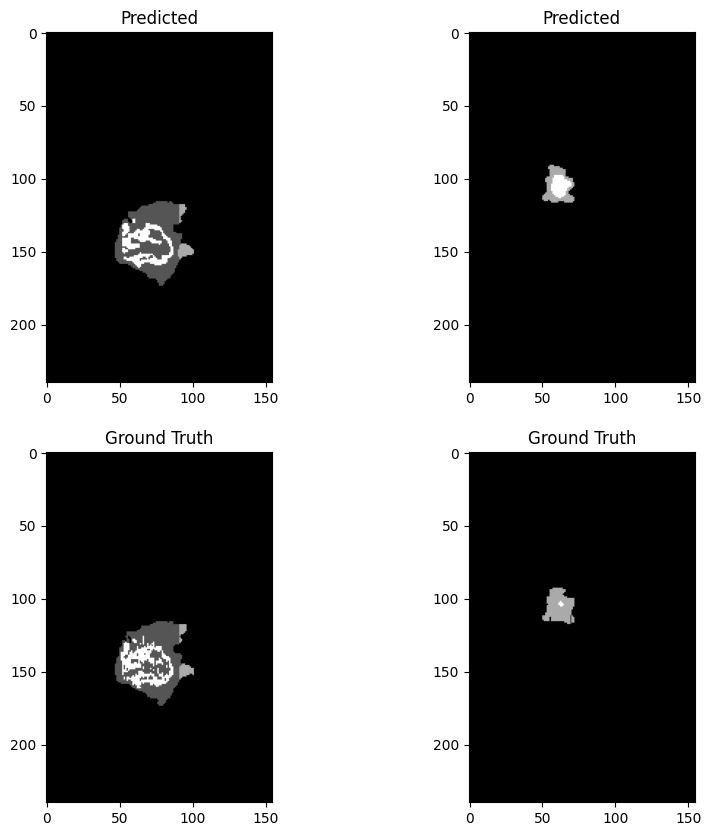

100%|██████████| 118/118 [01:11<00:00,  1.65it/s]


Average Validation Loss: 0.007467863477482382

Average Validation DSC: [0.9993347  0.93429609 0.94681761 0.80438114]
Average Validation ASSD: [ 0.06488866  8.12373679  9.90274165 22.72425243]
Epoch 47/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


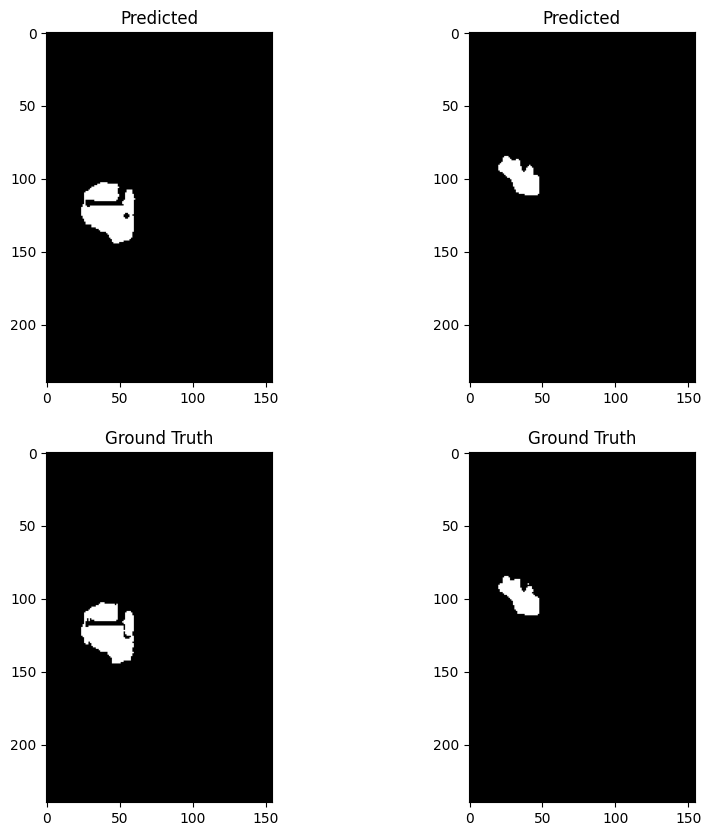

100%|██████████| 472/472 [05:32<00:00,  1.42it/s]



Average Training Loss: 0.004301279654748091

Average Training DSC: [0.99949883 0.95918976 0.96286396 0.85866058]
Average Training ASSD: [ 0.04338943  1.97798971  5.49969168 15.90340719]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


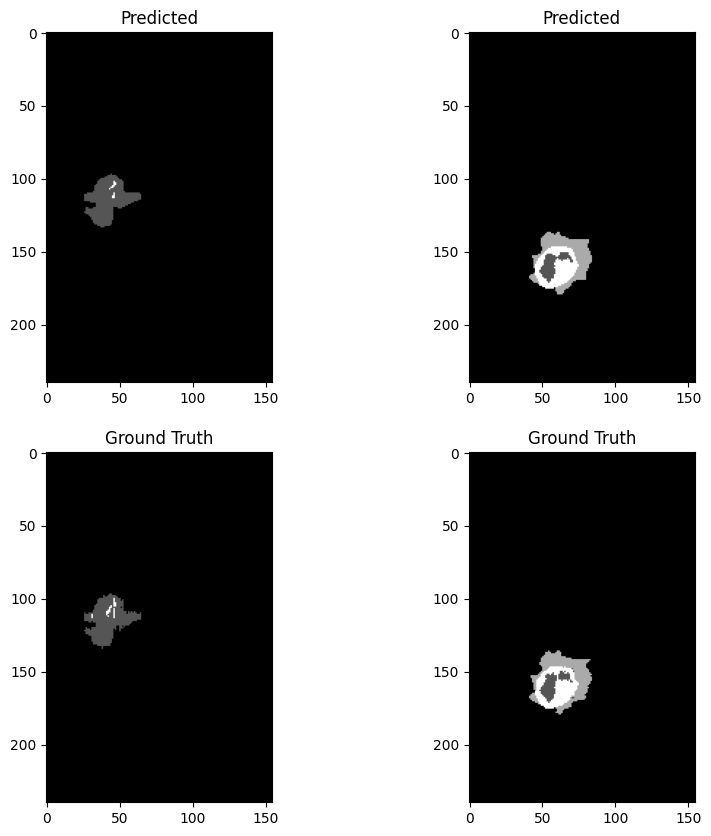

100%|██████████| 118/118 [01:12<00:00,  1.64it/s]


Average Validation Loss: 0.007546355551250784

Average Validation DSC: [0.99934087 0.93658875 0.94640399 0.8093924 ]
Average Validation ASSD: [ 0.06203549  7.53843022  9.32842084 21.15815917]
Epoch 48/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


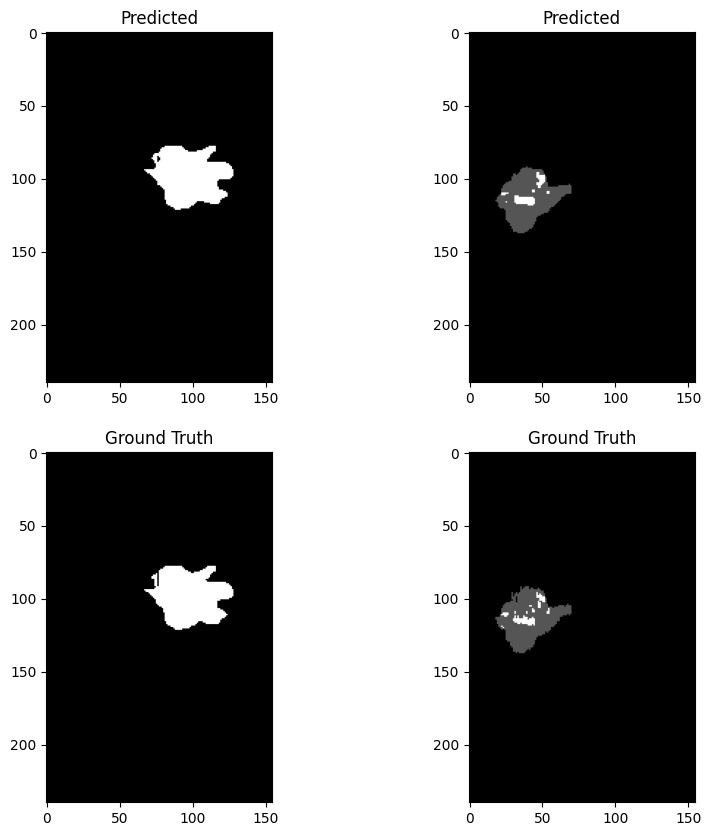

100%|██████████| 472/472 [05:32<00:00,  1.42it/s]



Average Training Loss: 0.0041867805047008065

Average Training DSC: [0.99951453 0.95999927 0.96358689 0.86208663]
Average Training ASSD: [ 0.04169581  1.97178569  5.09312893 16.02105709]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


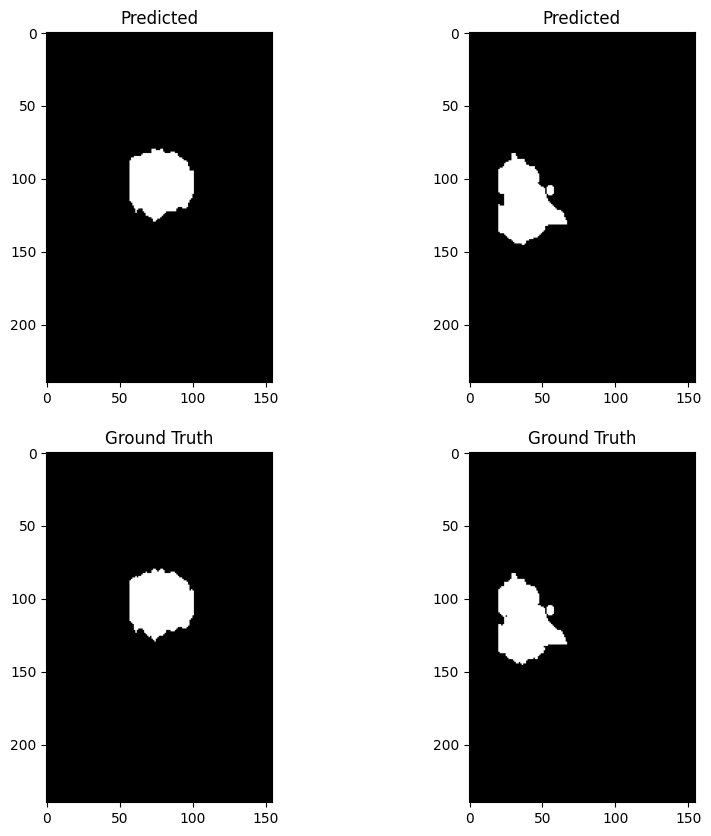

100%|██████████| 118/118 [01:12<00:00,  1.64it/s]


Average Validation Loss: 0.00749421442693131

Average Validation DSC: [0.99935488 0.93694093 0.94812269 0.81038096]
Average Validation ASSD: [ 0.06180985  7.53649631  9.31707323 20.3936382 ]
Epoch 49/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


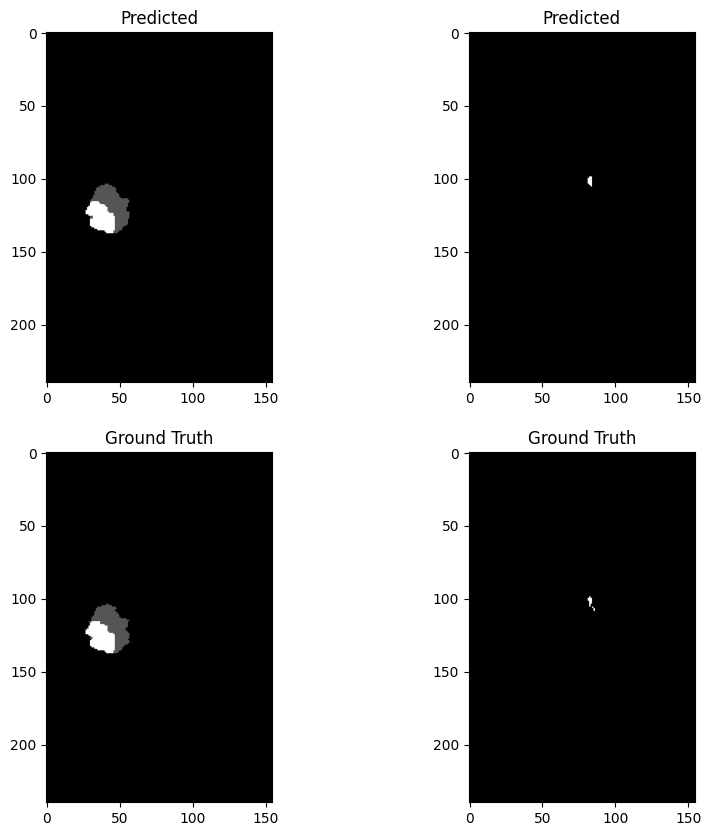

100%|██████████| 472/472 [05:33<00:00,  1.41it/s]



Average Training Loss: 0.004695554100612368

Average Training DSC: [0.99947406 0.95327011 0.96192984 0.85329476]
Average Training ASSD: [ 0.04534955  3.28668046  5.2961457  15.23028088]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


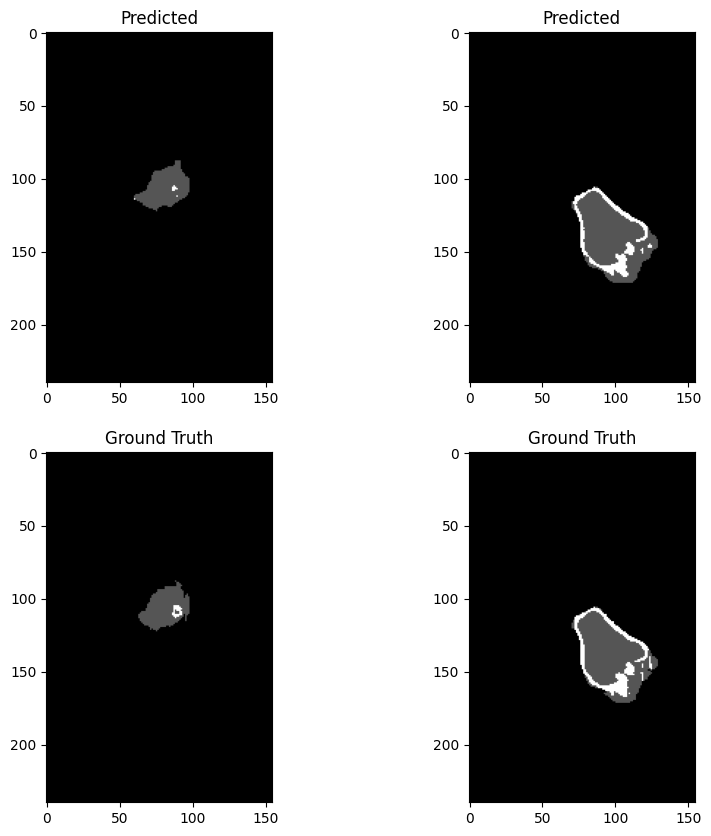

100%|██████████| 118/118 [01:12<00:00,  1.64it/s]


Average Validation Loss: 0.008892128709703684

Average Validation DSC: [0.99923458 0.91972871 0.92849703 0.76277338]
Average Validation ASSD: [ 0.07213538 11.06723034 12.69762075 23.89161224]
Epoch 50/50
-------------------------


  0%|          | 0/472 [00:00<?, ?it/s]

Training Prediction Visualization:


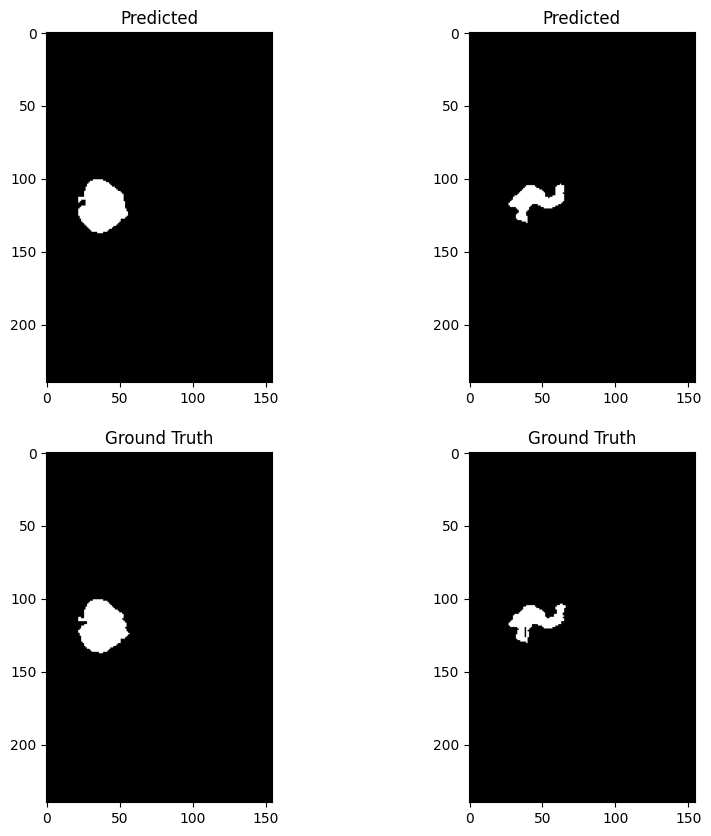

100%|██████████| 472/472 [05:32<00:00,  1.42it/s]



Average Training Loss: 0.005961528883544507

Average Training DSC: [0.99932169 0.93213642 0.95115257 0.82522705]
Average Training ASSD: [ 0.06482665  8.90100438  7.73082775 18.11746771]


  0%|          | 0/118 [00:00<?, ?it/s]

Validation Prediction Visualization:


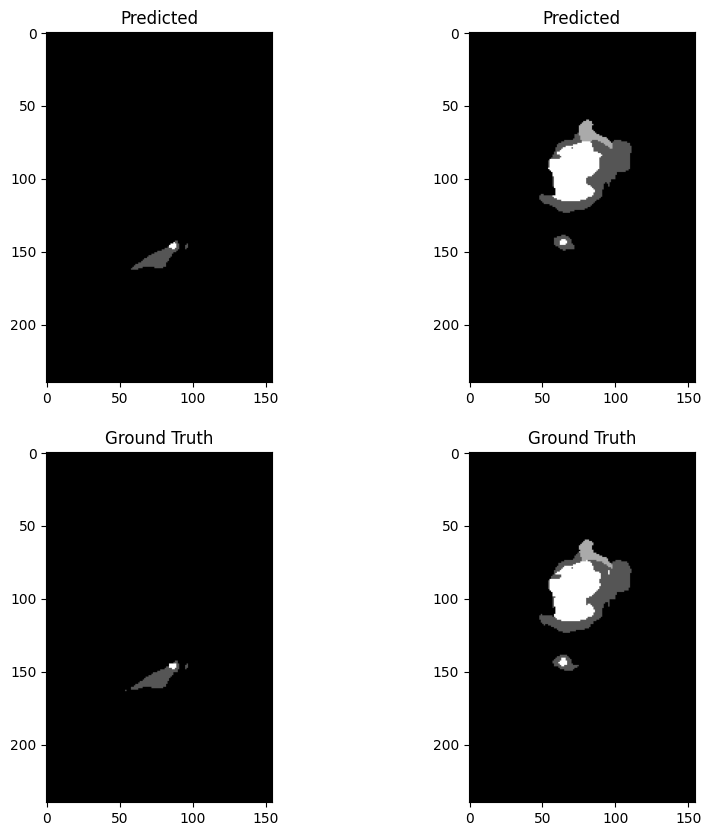

100%|██████████| 118/118 [01:11<00:00,  1.65it/s]


Average Validation Loss: 0.007886532711859602

Average Validation DSC: [0.9992472  0.92270096 0.94390966 0.7995901 ]
Average Validation ASSD: [ 0.07234246 10.47059869  9.95015208 20.89410127]


In [55]:
model = train_model(num_epochs = 50)